# Integrate the odes to check property P

## Imports

In [1]:
from mpmath import mp
from mpmath import mpf,mpc
import sage.libs.mpmath.all as a
mp.pretty = True
from timeit import default_timer as timer
# start=timer()
# end=timer()

## Functions to analyze the odes over a range of parameters
Each ode is parametrized by two numbers, $\sigma$ and $\alpha$ which are functions of
<UL><LI> $j$ and $\epsilon$ for odes ${\bf 3}_{j}$, ${\bf 2}_{j}$, and ${\bf 1}_{j}$  
     <LI>$\epsilon$ for ode ${\bf 2}$.
</UL>


### function to analyze ode 3$_{j}$, 2$_{j}$, or 1$_{j}$ at $j=\infty$ for list of $\sigma$ values
The limit $j\rightarrow \infty$ is taken with $\sigma$ fixed.


In [2]:
def process_sigma_list():
    global jval,epsilonb,sigmaval,alphaval
    global data_asymp
    set_precision()
    initialize_ode()
    for sigma_arg in sigma_list:
        epsilonb=0.0
        set_Jacobi_parameters()
        sigmaval=myR(sigma_arg)
        jval=Infinity
        alphaval = myR(limit(alphaexp,j=jval))
        #
        analyze_monodromy()
        if GOOD:
            data[ode_name]['asymp'][sigmaval]=data_dict

### function to analyze ode 3$_{j}$, 2$_{j}$, or 1$_{j}$ for list of $j$ values given $\epsilon$

In [3]:
def process_j_list():
    global jval,sigmaval,alphaval
    global data_j
    set_precision()
    initialize_ode()
    set_Jacobi_parameters()
    eps_string = epsilonb.str(digits=4,skip_zeroes=True)
    for j_arg in j_list:
        jval = j_arg
        alphaval = myR(alphaexp.subs(j=jval))
        sigmaval = myR(sigmaexp.subs(j=jval,epsb=myR(epsilonb)))
        #
        analyze_monodromy()
        if GOOD:
            if eps_string not in data[ode_name]['finite']:
                data[ode_name]['finite'][eps_string]={}
            data[ode_name]['finite'][eps_string][jval]=data_dict

### Function to analyze ode 2 for list of $\epsilon$ values

In [4]:
def process_ode2_epsilonb_list():
    global jval,epsilonb,sigmaval,alphaval,ode_decimal_precision
    global data_small_j
    set_precision()
    initialize_ode()
    jval=None
    for epsilonb_arg in epsilonb_list:
        epsilonb=epsilonb_arg
        eps_string = epsilonb.str(digits=4,skip_zeroes=True)
        set_Jacobi_parameters()
        alphaval = myR(alphaexp)
        sigmaval = myR(sigmaexp.subs(epsb=myR(epsilonb)))
        #
        analyze_monodromy()
        if GOOD:
            data[ode_name][eps_string]=data_dict

## Function to analyze imaginary period monodromy matrix

In [5]:
def analyze_monodromy():
    global data_dict,GOOD
    start = timer()
    GOOD=True
    if gauged:
        construct_gauge()
    mp.dps=ode_decimal_precision
    create_ode()
    start_ode=timer()
    calculate_Mi()
    end_ode=timer();
    ode_time = end_ode-start_ode
    mp.dps=high_decimal_precision
    check_Mi()
    if gauged:
        check_gauge_invariance()
        construct_Vphys()
    construct_Mi_phys()
    check_property_P()
    if property_P:
        calculate_frequencies()
        end=timer()
        total_time = end-start
        eps_string = epsilonb.str(digits=4,skip_zeroes=True)
        pretty_print(LE('\\epsilon ='), eps_string,LE('\\quad j ='), jval,\
            LE('\\quad\\sigma ='), n(sigmaval,digits=3), LE('\\quad(\\omega/\\sigma)^{2}='), mpstr(fs_ratio),\
                        '   (', ode_decimal_precision,', ', decimal_tol, ')', \
                     '    ode time = ', n(ode_time,digits=5), '   other time = ',  n(total_time-ode_time,digits=5) )
    if GOOD:
        data_dict = dictify_vars('jval','sigmaval','epsilonb','fs_ratio','Mi','Mi_phys','H','Vmat',\
                                 'ode_decimal_precision','high_decimal_precision',\
                    'N','gauged','H_eigenvalues','min_H_eigenvalue','positive_frequencies','negative_frequencies',\
                    'MiR','Mi_eigenvalues')

### subroutines

In [6]:
def calculate_Mi():
    global Mi4,Mi2,Mi
    Mi4 = cP(Jac_Kp)
    Mi2 = cR*Omega*Mi4.transpose()*Omega*cR*Mi4
    Mi = Omega*Mi2.transpose_conj()*Omega*Mi2

In [7]:
def check_Mi():
    global GOOD
    if not aeq(mp.det(Mi),1):
        GOOD=False
        print ('FAIL: Mi does not have det 1')
    if not aeq(Mi.transpose()*Omega*Mi,Omega):
        GOOD=False
        print ('FAIL: Mi is not symplectic')

In [8]:
def check_gauge_invariance():
    global GOOD
    if not aeq(Wgauge,Mi*Wgauge): 
        GOOD = False
        print('Mi FAILS gauge invariance check') 

In [9]:
def construct_Vphys():
    global Vmat,GOOD
    Proj_rem = Proj_phys
    Nphys = N-1
    vlist=[]
    vplist=[]
    for ii in range(Nphys):
        v = mp.matrix(int(Crank),int(1))
        v[ii]=1
        vphys = Proj_rem*v
        vphys = (1/mp.norm(vphys))*vphys
        vpphys = mp.j*Omega*vphys
        vlist.append(vphys)
        vplist.append(vpphys)
        Proj_rem = Proj_rem - vphys*vphys.transpose()- vpphys*vpphys.transpose()
    Vmat = mp.matrix(int(Crank),int(0))
    for ii in range(Nphys):
        Vmat=mp.extend(Vmat,vlist[ii])
    for ii in range(Nphys):
        Vmat=mp.extend(Vmat,vplist[ii])
    if not aeq(Vmat.transpose()*Vmat,mp.eye(int(2*Nphys))):
        GOOD=False
        print('FAIL Vmat^t Vmat not = 1')

In [10]:
def construct_Mi_phys():
    global Mi_phys, Omega_phys,GOOD
    if gauged:
        Mi_phys = Vmat.transpose()*Mi*Vmat
        Omega_phys = Vmat.transpose()*Omega*Vmat
        if not aeq(mp.det(Mi_phys),1):
            GOOD=False
            print('FAIL Mi_phys not det 1')
        if not aeq(Mi_phys.transpose()*Omega_phys*Mi_phys,Omega_phys):
            GOOD=False
            print('FAIL Mi_phys not symplectic')
    else:
        Mi_phys = Mi
        Omega_phys = Omega

In [11]:
def check_property_P():
    global H,H_eigenvalues,property_P,min_H_eigenvalue,HR,GOOD
    H=Omega_phys*Mi_phys-Omega_phys
    H_eigenvalues_complex,HR = mp.eig(H)
    property_P = False
    if not aeq(H,H.transpose_conj()):
        GOOD=False
        print('H FAILS to be hermitian')
        return
    H_eigenvalues=[]
    for x in H_eigenvalues_complex:
        if a0(mp.im(x)):
            H_eigenvalues.append(mp.re(x))
        else:
            GOOD=False
            print('H FAILS with non-real eigenvalue')
    H_eigenvalues.sort()
    min_H_eigenvalue = H_eigenvalues[0]
    if min_H_eigenvalue > 0:
        property_P = True
    else:
        GOOD=False
        print('FAILS Property P')
    return

In [12]:
def calculate_frequencies():
    global Mi_phys,Mi_eigenvalues,positive_frequencies,negative_frequencies,min_frequency,MiR,GOOD,fs_ratio
    if not aeq(Mi_phys.transpose_conj()*H, H*Mi_phys):
        GOOD=False
        print('FAIL Mi_phys is not H-hermitian')
    Mi_eigenvalues_complex,MiR = mp.eig(Mi_phys)
    Mi_eigenvalues=[]
    for x in Mi_eigenvalues_complex:
        if a0(mp.im(x)):
            Mi_eigenvalues.append(mp.re(x))
        else:
            GOOD=False
            pretty_print('Mi FAILS: non-real eigenvalue')
    positive_frequencies =[]
    negative_frequencies =[]
    for x in Mi_eigenvalues:
        if x < 0:
            GOOD=False
            print('FAIL: Mi_phys negative eigenvalue')
        else:
            freq = mp.ln(x)/(4*Jac_Kp)
            if freq == 0:
                GOOD=False
                print('FAIL zero frequency')
            if freq < 0:
                negative_frequencies.append(freq)
            else:
                positive_frequencies.append(freq)
    if(len(negative_frequencies) != len(positive_frequencies)):
        GOOD=False
        print('FAIL Mi_phys number of positive and negative frequencies differ')
    negative_frequencies.sort(reverse=True)
    positive_frequencies.sort()
    for neg,pos in zip(negative_frequencies,positive_frequencies):
        if not aeq(-neg,pos):
            GOOD=False
            print('FAIL frequencies not in +- pairs')
    min_frequency = positive_frequencies[0]
    fs_ratio= (min_frequency/sigmaval)^2
    if N == 3:
        if not aeq(positive_frequencies[0],positive_frequencies[1]):
            print('DEGENERACY BROKEN')

### subroutines for the ode solver
<UL><LI> initial condition at $\tau=0$ is $y_0=1$ the identity matrix
    <LI> K2mat, K1mat, K0mat are numerical matrices provided by Sagemath
    <LI> y_deriv(tau,y) calculates $\partial_\tau y = -i A(\tau) y$
    <LI> for the ode solver, the complex matrix $y$ is converted to a flat list
             of real numbers
    <LI> the solution mp.odefun(y_deriv ,0,y_init) is function of $\tau$
        that returns a flat list.
    <LI>  The propagator $P(\tau)$ is extracted from the solution function.
            </UL>

In [13]:
def create_ode():
    global cPlist,K0,K1,K2
    K0matval = K0mat.subs(alpha=alphaval)
    K2 = mpify_matrix(K2mat)
    K1 = mpify_matrix(K1mat*sigmaval)
    K0 = mpify_matrix(K0matval*sigmaval^2)
#  create ode
    cPlist = mp.odefun(y_deriv ,0,y_init,tol=ode_tol,degree=ode_degree)  

In [14]:
def construct_gauge():
    global Wgauge, Wpgauge, Proj_gauge, Proj_phys
    w0matval = w0mat.subs(alpha=alphaval)
    w1 = w1mat.change_ring(myC)
    w0 = (w0matval * sigmaval).change_ring(myC)
    zeroNvector = matrix(N,1)
    W0 = mpify_matrix(block_matrix(2,1,[w0,zeroNvector]))
    W1 = mpify_matrix(block_matrix(2,1,[w1,zeroNvector]))
    W1p = mpify_matrix(block_matrix(2,1,[zeroNvector,w1]))
    Wgauge = W0 + W1*F_at_K+ W1p*Fp_at_K
    Wpgauge = mp.j*Omega*Wgauge
    Proj_gauge = mp.eye(int(Crank)) - Wpgauge * mp.inverse(Wpgauge.transpose()*Wpgauge) * Wpgauge.transpose()
    Proj_phys = Proj_gauge - Wgauge* mp.inverse(Wgauge.transpose()*Wgauge) * Wgauge.transpose()

In [15]:
def y_deriv(tau,y):
# y is a list of length 4N * Crank
#     representing wr, wr', wi, wi'
# 
    Fi = -Jac_k * Jac_kp * mp.ellipfun('sd',u=tau,m=Jac_mp)
    Kr = K2*Fi^2 - K0
    Ny_4= N*Crank
    Ny_2= 2* Ny_4
    y1 = y[:Ny_2]
    y2 = y[Ny_2:]
    wr = matrixify_list(y1[:Ny_4],N,Crank)
    wpr = matrixify_list(y1[Ny_4:],N,Crank)
    wi = matrixify_list(y2[:Ny_4],N,Crank)
    wpi = matrixify_list(y2[Ny_4:],N,Crank)
    dwr = -wpi
    dwi = wpr
    dwpr = -Kr*wi+ Fi*(K1*wr)
    dwpi = Kr*wr + Fi*(K1*wi)
    dylist = listify_matrix(dwr) + listify_matrix(dwpr) + listify_matrix(dwi) + listify_matrix(dwpi)
    return dylist

In [16]:
def cP(tau):
    cPl = cPlist(tau)
    cPreal = mp.matrix([cPl[nn:nn+Crank] for nn in range(0,Crank*Crank,Crank)])
    cPimag = mp.matrix([cPl[nn:nn+Crank] for nn in range(Crank*Crank,Crank*Rrank,Crank)])
    cP_mp = cPreal+mp.j*cPimag
    return (cP_mp)

## Initialization functions

In [17]:
def set_ranks():
    global Crank, Rrank, IN, ZN, Z2N, Omega, cR, y_init
    Crank = 2*N
    Rrank = 2*Crank
    IN = identity_matrix(Reals,N)
    ZN = matrix(Reals,N,N)
    I2N = identity_matrix(Reals,2*N)
    Z2N = matrix(Reals,2*N,2*N)
    Omega_sage = I*block_matrix([[ZN,IN],[-IN,ZN]])
    cR_sage= block_matrix([[IN,ZN],[ZN,-IN]])
    Omega = mpify_matrix(Omega_sage)
    cR = mpify_matrix(cR_sage)
    y_init_matrix_sage = block_matrix([[I2N],[Z2N]])
    y_init_matrix = mpify_matrix(y_init_matrix_sage)
    y_init = listify_matrix(y_init_matrix)

In [18]:
def initialize_ode():
    global ode,K2mat,K1mat,K0mat,K1coeff,K0coeff,alphaexp,sigmaexp,gauged,w1mat,w0mat,w0coeff,N
    ode = odes[ode_name]
    K2mat = ode['K2mat']
    K1mat = ode['K1mat']
    K0mat = ode['K0mat']
    alphaexp = ode['alphaexp']
    sigmaexp = ode['sigmaexp']
    gauged = ode['gauged']
    if gauged:
        w1mat = ode['w1mat']
        w0mat = ode['w0mat']
    N=K2mat.nrows()
    set_ranks()

### Set precision and tolerances
<UL>
    <LI> mp.dps and decimal_tol are set in the main code
    <LI> mp.dps is the decimal precision for mpmath.
    <LI> 10^{-decimal_tol} is the tolerance for approximate numerical equality.
        </UL>
The precision of Sagemath real and complex numbers is set to match the mpmath precision



In [19]:
def set_precision():
    global binary_precision,Reals, RealNumber, myR, Complexes, ComplexNumber, myC, I, J
    global mptol, ode_tol,ode_degree
#    mp.dps = decimal_precision
#    binary_precision = mp.prec
#
    binary_precision=mp.prec
    Reals = RealField(binary_precision)
    RealNumber = Reals
    myR = Reals
    Complexes = ComplexField(binary_precision)
    ComplexNumber = Complexes
    myC = Complexes
    I = myC(I)
#    set_tolerances
    mptol = mpf(10^(-decimal_tol))
    ode_tol = None
    ode_degree = None
#    print ('mp decimal precision =',decimal_precision, '    mp binary precision = sage binary precision =', binary_precision )

### Set Jacobi parameters

In [20]:
def set_Jacobi_parameters():
    global epsilonb,Jac_m,Jac_mp,Jac_k,Jac_kp,Jac_K,Jac_Kp,F_at_K,Fp_at_K
    Jac_m = mpf(1/2) + mpf(epsilonb)^2
    Jac_mp = mpf(1)-Jac_m
    Jac_k = mp.sqrt(Jac_m)
    Jac_kp = mp.sqrt(Jac_mp)
    Jac_K = mp.ellipk(Jac_m)
    Jac_Kp = mp.ellipk(Jac_mp)
    F_at_K = 0.0
    Fp_at_K = - Jac_k* Jac_kp

## Utilities

In [21]:
%display latex
def LE(str):
    return(LatexExpr(r''+ str))

def flatten_list(L):
    return [val for sublist in L for val in sublist]

def mpify_matrix(matrix_sage):
    return mp.matrix(list(map(list,list(matrix_sage))))

def sagify(x):
    return a.mpmath_to_sage(x,binary_precision)

def sagify_matrix(matrix_mp):
    return matrix([list(map(sagify,sublist)) for sublist in matrix_mp.tolist()])

def matrixify_list(ylist,nrows,ncols):
    return mp.matrix([[ylist[ii+jj] for jj in range(ncols)] for ii in range(0,nrows*ncols,ncols)])

def listify_matrix(mp_matrix):
    return flatten_list(mp_matrix.tolist())

print_digits = 20
def mpstr(x):
    if type(x) is list:
        return list(map(mpstr,x))
    return mp.nstr(x,print_digits)

dictify_vars = lambda *args: {i:eval(i) for i in args}

multby = lambda n,x: [n*item for item in x]

### Numerical closeness utilities
$\text{mptol}   = $ approximate equality tolerance
$z\approx 0 \equiv |z| < \text{mptol}$  

$\mathbf{a0(x)}\quad\mathrm{ iff \quad x.norm()\;<\;tol}{}^{2}$
##### aeq(x,y) iff $\mathrm{(x-y).norm}()\;<\mathrm{tol}^2$
##### clean(x)
<UL><LI> if $x$ real, if a0(x) set x=0
    <LI> if $x$ complex, set real and imaginary parts to 0 if a0
        <LI> otherwise assume $x$ is a matrix and clean its entries
    </UL>

In [22]:
def almosteq(x,y):
    return(mp.almosteq(x,y,mptol))
#
def aeq(x,y):
    if isinstance(x,mp.mpf) or isinstance(x,mp.mpc):
        return(almosteq(x,y))
    if isinstance(x,mp.matrix):
        return(almosteq(mp.norm(x-y),0))
def a0(x):
    if isinstance(x,mp.mpf) or isinstance(x,mp.mpc):
        return(almosteq(x,0))
    if isinstance(x,mp.matrix):
        return(almosteq(mp.norm(x),0))
def clean(x):
    if isinstance(x,mpf):
        y=x
        if a0(y):
            y = mpf(0)
        if aeq(y,1.0):
            y = mpf(1.0)
        if aeq(y,-1.0):
            y = mpf(-1.0)
        return y        
    if isinstance(x,mpc):
        xRe=clean(mp.re(x))
        xIm=clean(mp.im(x))
        if xIm == mpf(0):
            return(xRe)
        elif xRe == mpf(0):
            return(mp.j*xIm)
        else:
            return (xRe + mp.j* xIm)
    if type(x) is list:
        return(list(map(clean,x)))
    if isinstance(x,mp.matrix):
        xrows=x.rows
        xcols=x.cols
        y = mp.matrix(xrows,xcols)
        for i in range(xrows):
            for j in range(xcols):
                y[i,j]= clean(x[i,j])
        return y

## Global variables

In [23]:
#     global Crank, Rrank, IN, ZN, Z2N, Omega, cR, y_init
#     global ode,K2mat,K1mat,K0mat,K1coeff,K0coeff,alphaexp,sigmaexp,gauged,w1mat,w0mat,w0coeff,N
#     global alpha_asymp, K0mat_asymp, w0mat_asymp
#     global binary_precision,Reals, RealNumber, myR, Complexes, ComplexNumber, myC, I, J
#     global epsilonb,Jac_m,Jac_mp,Jac_k,Jac_kp,Jac_K,Jac_Kp,F_at_t,Fp_at_t
#     global mptol, ode_tol,ode_degree
#     global cPlist,K0,K1,K2, Wgauge, Wpgauge, Proj_gauge, Proj_phys
#     global Mi4,Mi2,Mi
#     global GOOD
#     global Vmat,GOOD
#     global Mi_phys, Omega_phys,GOOD
#     global H,H_eigenvalues,property_P,min_H_eigenvalue,HR,GOOD
#     global Mi_phys,Mi_eigenvalues,positive_frequencies,negative_frequencies,min_frequency,MiR,GOOD

## Check gauge invariance of $P(\tau)$

This can be used after a run, i.e. after an ode solution is found.

In [24]:
def F(tau):
    return(Jac_k* mp.ellipfun('cn',u=Jac_K+mp.j*tau,m=Jac_m))
def Fp(tau):
    return(- Jac_k* mp.ellipfun('sn',u=Jac_K+mp.j*tau,m=Jac_m)* mp.ellipfun('dn',u=Jac_K+mp.j*tau,m=Jac_m))
def Fi(tau):
    return(-Jac_k * Jac_kp * mp.ellipfun('sd',u=tau,m=Jac_mp))
def Wg(tau):
    w0matval = w0mat.subs(alpha=alphaval)
    w1 = w1mat.change_ring(myC)
    w0 = (w0matval * w0coeff.subs(sigma=sigmaval)).change_ring(myC)
    zeroNvector = matrix(N,1)
    W0 = mpify_matrix(block_matrix(2,1,[w0,zeroNvector]))
    W1 = mpify_matrix(block_matrix(2,1,[w1,zeroNvector]))
    W1p = mpify_matrix(block_matrix(2,1,[zeroNvector,w1]))
    return(W0 + W1*F(tau)+ W1p*Fp(tau))


## Run the analyses

Integrating the ode requires a certain decimal precision in the ode solver.  
For each calculation below the decimal precision has been set by trial and error.  
Various consistency checks were made on each calculation.  
The decimal precision was raised until all the consistency checks were passed.

### load the odes, set precision and tolerance

In [25]:
odes=load('odes')
high_decimal_precision=300
mp.dps= high_decimal_precision
decimal_tol = 20
data = {}

### Ode 2

In [26]:
ode_name='2'
data[ode_name]={}

In [27]:
ode_decimal_precision = 30
epsilonb_list = [0.001,0.002,0.003,0.004,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7071]
process_ode2_epsilonb_list()

\epsilon = '0.001' \quad j = None \quad\sigma = 0.000707 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.6006 '   other time = ' 0.76988

\epsilon = '0.002' \quad j = None \quad\sigma = 0.00141 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.4197 '   other time = ' 0.27256

\epsilon = '0.003' \quad j = None \quad\sigma = 0.00212 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3831 '   other time = ' 0.27702

\epsilon = '0.004' \quad j = None \quad\sigma = 0.00283 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3885 '   other time = ' 0.27746

\epsilon = '0.005' \quad j = None \quad\sigma = 0.00354 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3839 '   other time = ' 0.27714

\epsilon = '0.01' \quad j = None \quad\sigma = 0.00707 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3782 '   other time = ' 0.27009

\epsilon = '0.02' \quad j = None \quad\sigma = 0.0141 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3872 '   other time = ' 0.26741

\epsilon = '0.03' \quad j = None \quad\sigma = 0.0212 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3786 '   other time = ' 0.26892

\epsilon = '0.04' \quad j = None \quad\sigma = 0.0283 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3819 '   other time = ' 0.26734

\epsilon = '0.05' \quad j = None \quad\sigma = 0.0354 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3894 '   other time = ' 0.26634

\epsilon = '0.1' \quad j = None \quad\sigma = 0.0707 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 4.3721 '   other time = ' 0.26822

\epsilon = '0.2' \quad j = None \quad\sigma = 0.141 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 3.9470 '   other time = ' 0.26340

\epsilon = '0.3' \quad j = None \quad\sigma = 0.212 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 3.8780 '   other time = ' 0.26140

\epsilon = '0.4' \quad j = None \quad\sigma = 0.283 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 3.8319 '   other time = ' 0.25747

\epsilon = '0.5' \quad j = None \quad\sigma = 0.354 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 3.3270 '   other time = ' 0.25333

\epsilon = '0.6' \quad j = None \quad\sigma = 0.424 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8495 '   other time = ' 0.24138

\epsilon = '0.7071' \quad j = None \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '2.0' '   (' 30 ', ' 20 ')' '    ode time = ' 1.0870 '   other time = ' 0.19430

### Ode $\mathbf{3_j}$

In [28]:
ode_name='3j'
data[ode_name]={}
data[ode_name]['asymp']={}
data[ode_name]['finite']={}

#### $j$ finite

In [29]:
epsilonb = 0.7071

ode_decimal_precision = 30
j_list = [3/2]
process_j_list()

ode_decimal_precision = 40
j_list = [2,5/2]
process_j_list()

ode_decimal_precision = 50
j_list = [3,7/2,4]
process_j_list()

ode_decimal_precision = 60
j_list = [9/2,5]
process_j_list()

\epsilon = '0.7071' \quad j = 3/2 \quad\sigma = 0.816 \quad(\omega/\sigma)^{2}= '4.4999834016824557022' '   (' 30 ', ' 20 ')' '    ode time = ' 1.3931 '   other time = ' 0.33249

\epsilon = '0.7071' \quad j = 2 \quad\sigma = 1.12 \quad(\omega/\sigma)^{2}= '5.1999897704981085583' '   (' 40 ', ' 20 ')' '    ode time = ' 3.3838 '   other time = ' 0.63626

\epsilon = '0.7071' \quad j = 5/2 \quad\sigma = 1.41 \quad(\omega/\sigma)^{2}= '5.4999932868850748519' '   (' 40 ', ' 20 ')' '    ode time = ' 3.3771 '   other time = ' 0.62858

\epsilon = '0.7071' \quad j = 3 \quad\sigma = 1.71 \quad(\omega/\sigma)^{2}= '5.6571381458966265831' '   (' 50 ', ' 20 ')' '    ode time = ' 7.4176 '   other time = ' 1.3600

\epsilon = '0.7071' \quad j = 7/2 \quad\sigma = 2.00 \quad(\omega/\sigma)^{2}= '5.749996519696881626' '   (' 50 ', ' 20 ')' '    ode time = ' 7.4287 '   other time = ' 1.3529

\epsilon = '0.7071' \quad j = 4 \quad\sigma = 2.29 \quad(\omega/\sigma)^{2}= '5.8095211363058142583' '   (' 50 ', ' 20 ')' '    ode time = ' 7.4138 '   other time = ' 1.3535

\epsilon = '0.7071' \quad j = 9/2 \quad\sigma = 2.58 \quad(\omega/\sigma)^{2}= '5.849997883443329219' '   (' 60 ', ' 20 ')' '    ode time = ' 14.721 '   other time = ' 2.7578

\epsilon = '0.7071' \quad j = 5 \quad\sigma = 2.87 \quad(\omega/\sigma)^{2}= '5.8787861619461414304' '   (' 60 ', ' 20 ')' '    ode time = ' 14.702 '   other time = ' 2.7476

In [30]:
epsilonb = 0.55

ode_decimal_precision = 30
j_list = [3/2,2]
process_j_list()

ode_decimal_precision = 40
j_list = [5/2,3,7/2]
process_j_list()

\epsilon = '0.55' \quad j = 3/2 \quad\sigma = 0.635 \quad(\omega/\sigma)^{2}= '4.0119140651818690656' '   (' 30 ', ' 20 ')' '    ode time = ' 3.5293 '   other time = ' 0.33699

\epsilon = '0.55' \quad j = 2 \quad\sigma = 0.870 \quad(\omega/\sigma)^{2}= '4.8782922295280631875' '   (' 30 ', ' 20 ')' '    ode time = ' 3.5297 '   other time = ' 0.33234

\epsilon = '0.55' \quad j = 5/2 \quad\sigma = 1.10 \quad(\omega/\sigma)^{2}= '5.284176568320185352' '   (' 40 ', ' 20 ')' '    ode time = ' 9.1205 '   other time = ' 0.81482

\epsilon = '0.55' \quad j = 3 \quad\sigma = 1.33 \quad(\omega/\sigma)^{2}= '5.5041350396067247139' '   (' 40 ', ' 20 ')' '    ode time = ' 9.1109 '   other time = ' 0.82106

\epsilon = '0.55' \quad j = 7/2 \quad\sigma = 1.56 \quad(\omega/\sigma)^{2}= '5.6363382785629739775' '   (' 40 ', ' 20 ')' '    ode time = ' 9.1179 '   other time = ' 0.81759

In [31]:
epsilonb = 0.4

ode_decimal_precision = 30
j_list = [3/2,2,5/2]
process_j_list()

ode_decimal_precision = 40
j_list = [3,7/2]
process_j_list()

\epsilon = '0.4' \quad j = 3/2 \quad\sigma = 0.462 \quad(\omega/\sigma)^{2}= '3.3043168365709716246' '   (' 30 ', ' 20 ')' '    ode time = ' 4.5847 '   other time = ' 0.34620

\epsilon = '0.4' \quad j = 2 \quad\sigma = 0.632 \quad(\omega/\sigma)^{2}= '4.2926629349963078598' '   (' 30 ', ' 20 ')' '    ode time = ' 4.5846 '   other time = ' 0.34422

\epsilon = '0.4' \quad j = 5/2 \quad\sigma = 0.800 \quad(\omega/\sigma)^{2}= '4.8595368961520156711' '   (' 30 ', ' 20 ')' '    ode time = ' 4.5844 '   other time = ' 0.34418

\epsilon = '0.4' \quad j = 3 \quad\sigma = 0.966 \quad(\omega/\sigma)^{2}= '5.192260255551817162' '   (' 40 ', ' 20 ')' '    ode time = ' 10.749 '   other time = ' 0.84987

\epsilon = '0.4' \quad j = 7/2 \quad\sigma = 1.13 \quad(\omega/\sigma)^{2}= '5.4001919850822057902' '   (' 40 ', ' 20 ')' '    ode time = ' 10.755 '   other time = ' 0.85234

In [32]:
epsilonb = 0.3

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3]
process_j_list()

ode_decimal_precision = 40
j_list = [7/2]
process_j_list()

\epsilon = '0.3' \quad j = 3/2 \quad\sigma = 0.346 \quad(\omega/\sigma)^{2}= '2.7500646261884110787' '   (' 30 ', ' 20 ')' '    ode time = ' 4.6443 '   other time = ' 0.35779

\epsilon = '0.3' \quad j = 2 \quad\sigma = 0.474 \quad(\omega/\sigma)^{2}= '3.6234231561114523133' '   (' 30 ', ' 20 ')' '    ode time = ' 4.6397 '   other time = ' 0.34864

\epsilon = '0.3' \quad j = 5/2 \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '4.2932101870569633592' '   (' 30 ', ' 20 ')' '    ode time = ' 4.6422 '   other time = ' 0.35106

\epsilon = '0.3' \quad j = 3 \quad\sigma = 0.725 \quad(\omega/\sigma)^{2}= '4.7452772824302272425' '   (' 30 ', ' 20 ')' '    ode time = ' 4.6379 '   other time = ' 0.34849

\epsilon = '0.3' \quad j = 7/2 \quad\sigma = 0.849 \quad(\omega/\sigma)^{2}= '5.0484406379829194185' '   (' 40 ', ' 20 ')' '    ode time = ' 12.154 '   other time = ' 0.86802

In [33]:
epsilonb = 0.01

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2,5,10,15,20,30,40,50,60,70,80,90]
process_j_list()

ode_decimal_precision = 40
j_list = [100,120,140,160]
process_j_list()

ode_decimal_precision = 50
j_list = [180,200,230]
process_j_list()

ode_decimal_precision = 70
j_list = [260,290,320,350]
process_j_list()

\epsilon = '0.01' \quad j = 3/2 \quad\sigma = 0.0115 \quad(\omega/\sigma)^{2}= '2.0006096917743312498' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2208 '   other time = ' 0.35648

\epsilon = '0.01' \quad j = 2 \quad\sigma = 0.0158 \quad(\omega/\sigma)^{2}= '2.001464161862771762' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2136 '   other time = ' 0.35290

\epsilon = '0.01' \quad j = 5/2 \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '2.0025643102199197761' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2110 '   other time = ' 0.35296

\epsilon = '0.01' \quad j = 3 \quad\sigma = 0.0242 \quad(\omega/\sigma)^{2}= '2.0039112915562727295' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2180 '   other time = ' 0.35330

\epsilon = '0.01' \quad j = 7/2 \quad\sigma = 0.0283 \quad(\omega/\sigma)^{2}= '2.005506513527785117' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2142 '   other time = ' 0.36143

\epsilon = '0.01' \quad j = 5 \quad\sigma = 0.0406 \quad(\omega/\sigma)^{2}= '2.0117994436223473306' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2140 '   other time = ' 0.35364

\epsilon = '0.01' \quad j = 10 \quad\sigma = 0.0816 \quad(\omega/\sigma)^{2}= '2.049915088956064386' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2188 '   other time = ' 0.35336

\epsilon = '0.01' \quad j = 15 \quad\sigma = 0.122 \quad(\omega/\sigma)^{2}= '2.1173874742746105617' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2201 '   other time = ' 0.35387

\epsilon = '0.01' \quad j = 20 \quad\sigma = 0.163 \quad(\omega/\sigma)^{2}= '2.2191564847884813161' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2160 '   other time = ' 0.35376

\epsilon = '0.01' \quad j = 30 \quad\sigma = 0.245 \quad(\omega/\sigma)^{2}= '2.5408502878760358795' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2151 '   other time = ' 0.35481

\epsilon = '0.01' \quad j = 40 \quad\sigma = 0.327 \quad(\omega/\sigma)^{2}= '3.0023297892601524571' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2159 '   other time = ' 0.35407

\epsilon = '0.01' \quad j = 50 \quad\sigma = 0.408 \quad(\omega/\sigma)^{2}= '3.5145618548029226805' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2127 '   other time = ' 0.35355

\epsilon = '0.01' \quad j = 60 \quad\sigma = 0.490 \quad(\omega/\sigma)^{2}= '3.9836417374816104468' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2192 '   other time = ' 0.35278

\epsilon = '0.01' \quad j = 70 \quad\sigma = 0.572 \quad(\omega/\sigma)^{2}= '4.3691189358253653385' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2169 '   other time = ' 0.35342

\epsilon = '0.01' \quad j = 80 \quad\sigma = 0.653 \quad(\omega/\sigma)^{2}= '4.6713878684154581544' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2242 '   other time = ' 0.35439

\epsilon = '0.01' \quad j = 90 \quad\sigma = 0.735 \quad(\omega/\sigma)^{2}= '4.905275304219552021' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2145 '   other time = ' 0.35925

\epsilon = '0.01' \quad j = 100 \quad\sigma = 0.816 \quad(\omega/\sigma)^{2}= '5.086722917739205928' '   (' 40 ', ' 20 ')' '    ode time = ' 12.503 '   other time = ' 0.88602

\epsilon = '0.01' \quad j = 120 \quad\sigma = 0.980 \quad(\omega/\sigma)^{2}= '5.3414664711113240511' '   (' 40 ', ' 20 ')' '    ode time = ' 12.492 '   other time = ' 0.88771

\epsilon = '0.01' \quad j = 140 \quad\sigma = 1.14 \quad(\omega/\sigma)^{2}= '5.5053424306333022703' '   (' 40 ', ' 20 ')' '    ode time = ' 13.734 '   other time = ' 0.88781

\epsilon = '0.01' \quad j = 160 \quad\sigma = 1.31 \quad(\omega/\sigma)^{2}= '5.615886790683154156' '   (' 40 ', ' 20 ')' '    ode time = ' 13.737 '   other time = ' 0.88991

\epsilon = '0.01' \quad j = 180 \quad\sigma = 1.47 \quad(\omega/\sigma)^{2}= '5.6935841252232656642' '   (' 50 ', ' 20 ')' '    ode time = ' 29.015 '   other time = ' 2.0776

\epsilon = '0.01' \quad j = 200 \quad\sigma = 1.63 \quad(\omega/\sigma)^{2}= '5.7501133827543736513' '   (' 50 ', ' 20 ')' '    ode time = ' 28.999 '   other time = ' 2.0672

\epsilon = '0.01' \quad j = 230 \quad\sigma = 1.88 \quad(\omega/\sigma)^{2}= '5.8097230117170114877' '   (' 50 ', ' 20 ')' '    ode time = ' 31.901 '   other time = ' 2.0864

\epsilon = '0.01' \quad j = 260 \quad\sigma = 2.12 \quad(\omega/\sigma)^{2}= '5.8504005667678360068' '   (' 70 ', ' 20 ')' '    ode time = ' 109.08 '   other time = ' 8.3613

\epsilon = '0.01' \quad j = 290 \quad\sigma = 2.37 \quad(\omega/\sigma)^{2}= '5.8793547844855359812' '   (' 70 ', ' 20 ')' '    ode time = ' 109.11 '   other time = ' 8.3742

\epsilon = '0.01' \quad j = 320 \quad\sigma = 2.61 \quad(\omega/\sigma)^{2}= '5.9006771964032691039' '   (' 70 ', ' 20 ')' '    ode time = ' 109.09 '   other time = ' 8.3869

\epsilon = '0.01' \quad j = 350 \quad\sigma = 2.86 \quad(\omega/\sigma)^{2}= '5.9168241864476698865' '   (' 70 ', ' 20 ')' '    ode time = ' 109.09 '   other time = ' 8.3868

#### $j= \infty$

In [34]:
ode_decimal_precision = 30
sigma_list = [0.02,0.04,.06,.08,.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,.6,0.65,0.7,0.75]
process_sigma_list()

ode_decimal_precision = 40
sigma_list = [0.8,0.85,0.9,0.95,1,1.2]
process_sigma_list()

ode_decimal_precision = 50
sigma_list = [1.4,1.6,1.8]
process_sigma_list()

ode_decimal_precision = 60
sigma_list = [2.0,2.2,2.4,2.6]
process_sigma_list()

ode_decimal_precision = 70
sigma_list = [2.8,3.0]
process_sigma_list()

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '2.0029306396589592143' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2236 '   other time = ' 0.39343

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0400 \quad(\omega/\sigma)^{2}= '2.01179637058130815' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2160 '   other time = ' 0.35387

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0600 \quad(\omega/\sigma)^{2}= '2.026815783726084496' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2137 '   other time = ' 0.35326

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0800 \quad(\omega/\sigma)^{2}= '2.0483431301388165799' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2211 '   other time = ' 0.35313

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.100 \quad(\omega/\sigma)^{2}= '2.0768512508711160382' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2145 '   other time = ' 0.35558

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.150 \quad(\omega/\sigma)^{2}= '2.1824734440870033519' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2211 '   other time = ' 0.35398

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.200 \quad(\omega/\sigma)^{2}= '2.3443219375813765233' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2149 '   other time = ' 0.35687

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.250 \quad(\omega/\sigma)^{2}= '2.5665348899140685796' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2161 '   other time = ' 0.35399

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '2.8416258944066673457' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2152 '   other time = ' 0.35379

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.350 \quad(\omega/\sigma)^{2}= '3.1493685608081772441' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2148 '   other time = ' 0.35361

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.400 \quad(\omega/\sigma)^{2}= '3.4640786507796314538' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2180 '   other time = ' 0.35349

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.450 \quad(\omega/\sigma)^{2}= '3.7641093098968960934' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2153 '   other time = ' 0.35513

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '4.0364870439793698411' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2225 '   other time = ' 0.35237

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.550 \quad(\omega/\sigma)^{2}= '4.2762245862832203116' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2150 '   other time = ' 0.35806

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '4.4835179731049804094' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2173 '   other time = ' 0.35414

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.650 \quad(\omega/\sigma)^{2}= '4.6611734256132470388' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2189 '   other time = ' 0.35309

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.700 \quad(\omega/\sigma)^{2}= '4.8129437327005195409' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2228 '   other time = ' 0.35358

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '4.9426438397638722761' '   (' 30 ', ' 20 ')' '    ode time = ' 5.2159 '   other time = ' 0.35461

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.800 \quad(\omega/\sigma)^{2}= '5.0537551161551944156' '   (' 40 ', ' 20 ')' '    ode time = ' 12.484 '   other time = ' 0.88884

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.850 \quad(\omega/\sigma)^{2}= '5.1492920034437529415' '   (' 40 ', ' 20 ')' '    ode time = ' 12.465 '   other time = ' 0.88868

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.900 \quad(\omega/\sigma)^{2}= '5.2317943046322504194' '   (' 40 ', ' 20 ')' '    ode time = ' 12.489 '   other time = ' 0.88517

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.950 \quad(\omega/\sigma)^{2}= '5.3033719781498695124' '   (' 40 ', ' 20 ')' '    ode time = ' 12.477 '   other time = ' 0.89113

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '5.3657663950167112016' '   (' 40 ', ' 20 ')' '    ode time = ' 13.708 '   other time = ' 0.88630

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.20 \quad(\omega/\sigma)^{2}= '5.5486814297827637433' '   (' 40 ', ' 20 ')' '    ode time = ' 13.738 '   other time = ' 0.88871

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.40 \quad(\omega/\sigma)^{2}= '5.6635970315408634098' '   (' 50 ', ' 20 ')' '    ode time = ' 29.013 '   other time = ' 2.0731

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.60 \quad(\omega/\sigma)^{2}= '5.7400474766166610879' '   (' 50 ', ' 20 ')' '    ode time = ' 29.027 '   other time = ' 2.0897

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.80 \quad(\omega/\sigma)^{2}= '5.793310029131846546' '   (' 50 ', ' 20 ')' '    ode time = ' 31.963 '   other time = ' 2.0759

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.00 \quad(\omega/\sigma)^{2}= '5.831831372906549483' '   (' 60 ', ' 20 ')' '    ode time = ' 59.779 '   other time = ' 4.4333

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.20 \quad(\omega/\sigma)^{2}= '5.8605596139979826243' '   (' 60 ', ' 20 ')' '    ode time = ' 59.829 '   other time = ' 4.4454

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.40 \quad(\omega/\sigma)^{2}= '5.8825388177663555004' '   (' 60 ', ' 20 ')' '    ode time = ' 65.649 '   other time = ' 4.4665

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.60 \quad(\omega/\sigma)^{2}= '5.8997208734549874499' '   (' 60 ', ' 20 ')' '    ode time = ' 65.545 '   other time = ' 4.4212

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.80 \quad(\omega/\sigma)^{2}= '5.9134022698348587444' '   (' 70 ', ' 20 ')' '    ode time = ' 108.59 '   other time = ' 8.3165

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 3.00 \quad(\omega/\sigma)^{2}= '5.9244706315060858988' '   (' 70 ', ' 20 ')' '    ode time = ' 108.56 '   other time = ' 8.3171

### Ode $\mathbf{2_j}$

In [35]:
ode_name='2j'
data[ode_name]={}
data[ode_name]['asymp']={}
data[ode_name]['finite']={}

#### $j$ finite

In [36]:
epsilonb = 0.7071

ode_decimal_precision = 30
j_list = [3/2]
process_j_list()

ode_decimal_precision = 40
j_list = [2,5/2]
process_j_list()

ode_decimal_precision = 50
j_list = [3,7/2,4]
process_j_list()

ode_decimal_precision = 60
j_list = [9/2,5]
process_j_list()

ode_decimal_precision = 70
j_list = [11/2]
process_j_list()

\epsilon = '0.7071' \quad j = 3/2 \quad\sigma = 1.06 \quad(\omega/\sigma)^{2}= '3.111105996386973974' '   (' 30 ', ' 20 ')' '    ode time = ' 1.1663 '   other time = ' 0.28558

\epsilon = '0.7071' \quad j = 2 \quad\sigma = 1.41 \quad(\omega/\sigma)^{2}= '3.4999961970124620313' '   (' 40 ', ' 20 ')' '    ode time = ' 3.0246 '   other time = ' 0.52854

\epsilon = '0.7071' \quad j = 5/2 \quad\sigma = 1.77 \quad(\omega/\sigma)^{2}= '3.6799973229185163812' '   (' 40 ', ' 20 ')' '    ode time = ' 3.0261 '   other time = ' 0.52670

\epsilon = '0.7071' \quad j = 3 \quad\sigma = 2.12 \quad(\omega/\sigma)^{2}= '3.7777758319480891792' '   (' 50 ', ' 20 ')' '    ode time = ' 6.9061 '   other time = ' 1.2123

\epsilon = '0.7071' \quad j = 7/2 \quad\sigma = 2.47 \quad(\omega/\sigma)^{2}= '3.8367332270254066081' '   (' 50 ', ' 20 ')' '    ode time = ' 6.9043 '   other time = ' 1.2123

\epsilon = '0.7071' \quad j = 4 \quad\sigma = 2.83 \quad(\omega/\sigma)^{2}= '3.8749988587702415691' '   (' 50 ', ' 20 ')' '    ode time = ' 6.9113 '   other time = ' 1.2110

\epsilon = '0.7071' \quad j = 9/2 \quad\sigma = 3.18 \quad(\omega/\sigma)^{2}= '3.9012336564667336' '   (' 60 ', ' 20 ')' '    ode time = ' 14.025 '   other time = ' 2.5632

\epsilon = '0.7071' \quad j = 5 \quad\sigma = 3.54 \quad(\omega/\sigma)^{2}= '3.9199992561534346762' '   (' 60 ', ' 20 ')' '    ode time = ' 14.014 '   other time = ' 2.5638

\epsilon = '0.7071' \quad j = 11/2 \quad\sigma = 3.89 \quad(\omega/\sigma)^{2}= '3.9338836793777357288' '   (' 70 ', ' 20 ')' '    ode time = ' 25.137 '   other time = ' 4.7541

In [37]:
epsilonb = 0.6

ode_decimal_precision = 30
j_list = [3/2]
process_j_list()

ode_decimal_precision = 40
j_list = [2,5/2,3]
process_j_list()

ode_decimal_precision = 50
j_list = [7/2]
process_j_list()

ode_decimal_precision = 50
j_list = [4]
process_j_list()

\epsilon = '0.6' \quad j = 3/2 \quad\sigma = 0.900 \quad(\omega/\sigma)^{2}= '3.0219757580714899217' '   (' 30 ', ' 20 ')' '    ode time = ' 2.6289 '   other time = ' 0.26299

\epsilon = '0.6' \quad j = 2 \quad\sigma = 1.20 \quad(\omega/\sigma)^{2}= '3.4289121173565929182' '   (' 40 ', ' 20 ')' '    ode time = ' 7.1452 '   other time = ' 0.70020

\epsilon = '0.6' \quad j = 5/2 \quad\sigma = 1.50 \quad(\omega/\sigma)^{2}= '3.628680571286386956' '   (' 40 ', ' 20 ')' '    ode time = ' 7.1397 '   other time = ' 0.69880

\epsilon = '0.6' \quad j = 3 \quad\sigma = 1.80 \quad(\omega/\sigma)^{2}= '3.7400155842771586464' '   (' 40 ', ' 20 ')' '    ode time = ' 7.1452 '   other time = ' 0.69994

\epsilon = '0.6' \quad j = 7/2 \quad\sigma = 2.10 \quad(\omega/\sigma)^{2}= '3.8080686609021688663' '   (' 50 ', ' 20 ')' '    ode time = ' 16.961 '   other time = ' 1.6797

\epsilon = '0.6' \quad j = 4 \quad\sigma = 2.40 \quad(\omega/\sigma)^{2}= '3.8525999135959532319' '   (' 50 ', ' 20 ')' '    ode time = ' 16.974 '   other time = ' 1.6814

In [38]:
epsilonb = 0.5

ode_decimal_precision = 30
j_list = [3/2,2]
process_j_list()

ode_decimal_precision = 40
j_list = [5/2,3,7/2]
process_j_list()

ode_decimal_precision = 50
j_list = [9/2]
process_j_list()

ode_decimal_precision = 60
j_list = [6]
process_j_list()

ode_decimal_precision = 70
j_list = [8]
process_j_list()

\epsilon = '0.5' \quad j = 3/2 \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '2.9252106564059074814' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1117 '   other time = ' 0.26875

\epsilon = '0.5' \quad j = 2 \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '3.336509692956312181' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1070 '   other time = ' 0.26379

\epsilon = '0.5' \quad j = 5/2 \quad\sigma = 1.25 \quad(\omega/\sigma)^{2}= '3.5574871095526227098' '   (' 40 ', ' 20 ')' '    ode time = ' 8.5732 '   other time = ' 0.72274

\epsilon = '0.5' \quad j = 3 \quad\sigma = 1.50 \quad(\omega/\sigma)^{2}= '3.6859375596307213748' '   (' 40 ', ' 20 ')' '    ode time = ' 8.5624 '   other time = ' 0.72395

\epsilon = '0.5' \quad j = 7/2 \quad\sigma = 1.75 \quad(\omega/\sigma)^{2}= '3.766268941358884203' '   (' 40 ', ' 20 ')' '    ode time = ' 8.5670 '   other time = ' 0.72235

\epsilon = '0.5' \quad j = 9/2 \quad\sigma = 2.25 \quad(\omega/\sigma)^{2}= '3.8566326173765722934' '   (' 50 ', ' 20 ')' '    ode time = ' 20.328 '   other time = ' 1.7738

\epsilon = '0.5' \quad j = 6 \quad\sigma = 3.00 \quad(\omega/\sigma)^{2}= '3.9186142347692286407' '   (' 60 ', ' 20 ')' '    ode time = ' 42.169 '   other time = ' 3.8635

\epsilon = '0.5' \quad j = 8 \quad\sigma = 4.00 \quad(\omega/\sigma)^{2}= '3.953986459962055927' '   (' 70 ', ' 20 ')' '    ode time = ' 77.547 '   other time = ' 7.3441

In [39]:
epsilonb = 0.4

ode_decimal_precision = 30
j_list = [3/2,2,5/2]
process_j_list()

ode_decimal_precision = 40
j_list = [3,7/2,9/2]
process_j_list()

ode_decimal_precision = 50
j_list = [11/2]
process_j_list()

\epsilon = '0.4' \quad j = 3/2 \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '2.8260860543995007448' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6120 '   other time = ' 0.28126

\epsilon = '0.4' \quad j = 2 \quad\sigma = 0.800 \quad(\omega/\sigma)^{2}= '3.2095538197436441631' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6121 '   other time = ' 0.27748

\epsilon = '0.4' \quad j = 5/2 \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '3.448496411453397044' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6040 '   other time = ' 0.27111

\epsilon = '0.4' \quad j = 3 \quad\sigma = 1.20 \quad(\omega/\sigma)^{2}= '3.5985568104045214463' '   (' 40 ', ' 20 ')' '    ode time = ' 9.9381 '   other time = ' 0.74665

\epsilon = '0.4' \quad j = 7/2 \quad\sigma = 1.40 \quad(\omega/\sigma)^{2}= '3.6966042108267113169' '   (' 40 ', ' 20 ')' '    ode time = ' 9.9436 '   other time = ' 0.74873

\epsilon = '0.4' \quad j = 9/2 \quad\sigma = 1.80 \quad(\omega/\sigma)^{2}= '3.8107346628228260028' '   (' 40 ', ' 20 ')' '    ode time = ' 9.9419 '   other time = ' 0.74667

\epsilon = '0.4' \quad j = 11/2 \quad\sigma = 2.20 \quad(\omega/\sigma)^{2}= '3.8713285468249709094' '   (' 50 ', ' 20 ')' '    ode time = ' 23.727 '   other time = ' 1.8277

In [40]:
epsilonb = 0.325

ode_decimal_precision = 30
j_list = [3/2,2,5/2]
process_j_list()

ode_decimal_precision = 40
j_list = [3,7/2]
process_j_list()

\epsilon = '0.325' \quad j = 3/2 \quad\sigma = 0.487 \quad(\omega/\sigma)^{2}= '2.7686172645363766041' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6586 '   other time = ' 0.27964

\epsilon = '0.325' \quad j = 2 \quad\sigma = 0.650 \quad(\omega/\sigma)^{2}= '3.0910012237972445732' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6586 '   other time = ' 0.27272

\epsilon = '0.325' \quad j = 5/2 \quad\sigma = 0.812 \quad(\omega/\sigma)^{2}= '3.3289994780980640365' '   (' 30 ', ' 20 ')' '    ode time = ' 3.6567 '   other time = ' 0.27338

\epsilon = '0.325' \quad j = 3 \quad\sigma = 0.975 \quad(\omega/\sigma)^{2}= '3.4945400530890411016' '   (' 40 ', ' 20 ')' '    ode time = ' 10.106 '   other time = ' 0.75690

\epsilon = '0.325' \quad j = 7/2 \quad\sigma = 1.14 \quad(\omega/\sigma)^{2}= '3.6096034560197983957' '   (' 40 ', ' 20 ')' '    ode time = ' 10.097 '   other time = ' 0.75594

In [41]:
epsilonb = 0.25

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]
process_j_list()

ode_decimal_precision = 40
j_list = [9/2,13/2]
process_j_list()

ode_decimal_precision = 50
j_list = [8,10]
process_j_list()

ode_decimal_precision = 70
j_list = [23/2,13,29/2]
process_j_list()

ode_decimal_precision = 70
j_list = [16]
process_j_list()

\epsilon = '0.25' \quad j = 3/2 \quad\sigma = 0.375 \quad(\omega/\sigma)^{2}= '2.7548735658800374599' '   (' 30 ', ' 20 ')' '    ode time = ' 4.2099 '   other time = ' 0.37515

\epsilon = '0.25' \quad j = 2 \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '2.9695797955370071617' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1040 '   other time = ' 0.27659

\epsilon = '0.25' \quad j = 5/2 \quad\sigma = 0.625 \quad(\omega/\sigma)^{2}= '3.1718000990866994758' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1106 '   other time = ' 0.27571

\epsilon = '0.25' \quad j = 3 \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '3.3384548001964306367' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1044 '   other time = ' 0.27612

\epsilon = '0.25' \quad j = 7/2 \quad\sigma = 0.875 \quad(\omega/\sigma)^{2}= '3.4682100918407403594' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1099 '   other time = ' 0.27591

\epsilon = '0.25' \quad j = 9/2 \quad\sigma = 1.12 \quad(\omega/\sigma)^{2}= '3.6434974763842416896' '   (' 40 ', ' 20 ')' '    ode time = ' 10.253 '   other time = ' 0.76829

\epsilon = '0.25' \quad j = 13/2 \quad\sigma = 1.62 \quad(\omega/\sigma)^{2}= '3.814084315501186252' '   (' 40 ', ' 20 ')' '    ode time = ' 11.384 '   other time = ' 0.76677

\epsilon = '0.25' \quad j = 8 \quad\sigma = 2.00 \quad(\omega/\sigma)^{2}= '3.8739450433276470651' '   (' 50 ', ' 20 ')' '    ode time = ' 24.435 '   other time = ' 1.8778

\epsilon = '0.25' \quad j = 10 \quad\sigma = 2.50 \quad(\omega/\sigma)^{2}= '3.917799937383960746' '   (' 50 ', ' 20 ')' '    ode time = ' 27.144 '   other time = ' 1.8812

\epsilon = '0.25' \quad j = 23/2 \quad\sigma = 2.88 \quad(\omega/\sigma)^{2}= '3.937337767536398566' '   (' 70 ', ' 20 ')' '    ode time = ' 93.658 '   other time = ' 7.9255

\epsilon = '0.25' \quad j = 13 \quad\sigma = 3.25 \quad(\omega/\sigma)^{2}= '3.9506944761876452264' '   (' 70 ', ' 20 ')' '    ode time = ' 93.619 '   other time = ' 7.9345

\epsilon = '0.25' \quad j = 29/2 \quad\sigma = 3.62 \quad(\omega/\sigma)^{2}= '3.96021425385399209' '   (' 70 ', ' 20 ')' '    ode time = ' 104.05 '   other time = ' 7.9300

\epsilon = '0.25' \quad j = 16 \quad\sigma = 4.00 \quad(\omega/\sigma)^{2}= '3.9672316450013068105' '   (' 70 ', ' 20 ')' '    ode time = ' 104.01 '   other time = ' 7.9302

In [42]:
epsilonb = 0.2

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]
process_j_list()

\epsilon = '0.2' \quad j = 3/2 \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '2.7900223637150635907' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1372 '   other time = ' 0.29612

\epsilon = '0.2' \quad j = 2 \quad\sigma = 0.400 \quad(\omega/\sigma)^{2}= '2.911889776281244591' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1461 '   other time = ' 0.27750

\epsilon = '0.2' \quad j = 5/2 \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '3.0584348766204516843' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1318 '   other time = ' 0.27782

\epsilon = '0.2' \quad j = 3 \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '3.2022972174391099247' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1413 '   other time = ' 0.28057

\epsilon = '0.2' \quad j = 7/2 \quad\sigma = 0.700 \quad(\omega/\sigma)^{2}= '3.3295574084657802527' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1351 '   other time = ' 0.27788

In [43]:
epsilonb = 0.15

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]
process_j_list()

\epsilon = '0.15' \quad j = 3/2 \quad\sigma = 0.225 \quad(\omega/\sigma)^{2}= '2.8767082020777589107' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1428 '   other time = ' 0.28276

\epsilon = '0.15' \quad j = 2 \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '2.9060034398802915749' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1402 '   other time = ' 0.28029

\epsilon = '0.15' \quad j = 5/2 \quad\sigma = 0.375 \quad(\omega/\sigma)^{2}= '2.9730112551102726957' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1373 '   other time = ' 0.28015

\epsilon = '0.15' \quad j = 3 \quad\sigma = 0.450 \quad(\omega/\sigma)^{2}= '3.0622401264067358881' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1603 '   other time = ' 0.28084

\epsilon = '0.15' \quad j = 7/2 \quad\sigma = 0.525 \quad(\omega/\sigma)^{2}= '3.1595334734424986648' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1475 '   other time = ' 0.28065

In [44]:
epsilonb = 0.125

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]
process_j_list()

\epsilon = '0.125' \quad j = 3/2 \quad\sigma = 0.188 \quad(\omega/\sigma)^{2}= '2.9419804646675092648' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1639 '   other time = ' 0.28233

\epsilon = '0.125' \quad j = 2 \quad\sigma = 0.250 \quad(\omega/\sigma)^{2}= '2.933976756786076842' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1609 '   other time = ' 0.27968

\epsilon = '0.125' \quad j = 5/2 \quad\sigma = 0.312 \quad(\omega/\sigma)^{2}= '2.9591701577989723021' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1634 '   other time = ' 0.28209

\epsilon = '0.125' \quad j = 3 \quad\sigma = 0.375 \quad(\omega/\sigma)^{2}= '3.0103722063219255875' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1644 '   other time = ' 0.28125

\epsilon = '0.125' \quad j = 7/2 \quad\sigma = 0.438 \quad(\omega/\sigma)^{2}= '3.0780823512890894891' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1616 '   other time = ' 0.28042

In [45]:
epsilonb = 0.1

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2,4]
process_j_list()

\epsilon = '0.1' \quad j = 3/2 \quad\sigma = 0.150 \quad(\omega/\sigma)^{2}= '3.0202372938491234705' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1767 '   other time = ' 0.28347

\epsilon = '0.1' \quad j = 2 \quad\sigma = 0.200 \quad(\omega/\sigma)^{2}= '2.9874597291297524231' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1706 '   other time = ' 0.28223

\epsilon = '0.1' \quad j = 5/2 \quad\sigma = 0.250 \quad(\omega/\sigma)^{2}= '2.9771606541773666915' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1698 '   other time = ' 0.28159

\epsilon = '0.1' \quad j = 3 \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '2.9892814480213505723' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1694 '   other time = ' 0.28071

\epsilon = '0.1' \quad j = 7/2 \quad\sigma = 0.350 \quad(\omega/\sigma)^{2}= '3.0200780860474762668' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1726 '   other time = ' 0.28083

\epsilon = '0.1' \quad j = 4 \quad\sigma = 0.400 \quad(\omega/\sigma)^{2}= '3.0645544106568858882' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1752 '   other time = ' 0.28119

In [46]:
epsilonb = 0.08

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2,4]
process_j_list()

\epsilon = '0.08' \quad j = 3/2 \quad\sigma = 0.120 \quad(\omega/\sigma)^{2}= '3.0885824003150966159' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1877 '   other time = ' 0.28467

\epsilon = '0.08' \quad j = 2 \quad\sigma = 0.160 \quad(\omega/\sigma)^{2}= '3.0482652232348396391' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1732 '   other time = ' 0.28186

\epsilon = '0.08' \quad j = 5/2 \quad\sigma = 0.200 \quad(\omega/\sigma)^{2}= '3.0195927817201708685' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1777 '   other time = ' 0.28124

\epsilon = '0.08' \quad j = 3 \quad\sigma = 0.240 \quad(\omega/\sigma)^{2}= '3.0059180001580421244' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1736 '   other time = ' 0.28072

\epsilon = '0.08' \quad j = 7/2 \quad\sigma = 0.280 \quad(\omega/\sigma)^{2}= '3.0073934028957272796' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1771 '   other time = ' 0.28022

\epsilon = '0.08' \quad j = 4 \quad\sigma = 0.320 \quad(\omega/\sigma)^{2}= '3.022377590477805206' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1732 '   other time = ' 0.28164

In [47]:
epsilonb = 0.01

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]+[m/2 for m in range(12,32,5)]+[m/2 for m in range(32,122,10)]
process_j_list()

j_list = [m/2 for m in range(122,182,20)]
process_j_list()

ode_decimal_precision = 40
j_list = [m/2 for m in range(182,342,20)]
process_j_list()

ode_decimal_precision = 50
j_list = [m/2 for m in range(342,502,40)]
process_j_list()

ode_decimal_precision = 60
j_list = [m/2 for m in range(500,660,80)]
process_j_list()

ode_decimal_precision = 80
j_list = [m/2 for m in range(660,820,80)]
process_j_list()

\epsilon = '0.01' \quad j = 3/2 \quad\sigma = 0.0150 \quad(\omega/\sigma)^{2}= '3.2672043864311006399' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1767 '   other time = ' 0.28252

\epsilon = '0.01' \quad j = 2 \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '3.2654202519516805471' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1784 '   other time = ' 0.28043

\epsilon = '0.01' \quad j = 5/2 \quad\sigma = 0.0250 \quad(\omega/\sigma)^{2}= '3.263148361992893767' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1756 '   other time = ' 0.28070

\epsilon = '0.01' \quad j = 3 \quad\sigma = 0.0300 \quad(\omega/\sigma)^{2}= '3.2604047479759726416' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1721 '   other time = ' 0.28314

\epsilon = '0.01' \quad j = 7/2 \quad\sigma = 0.0350 \quad(\omega/\sigma)^{2}= '3.2572085030256455228' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1723 '   other time = ' 0.28140

\epsilon = '0.01' \quad j = 6 \quad\sigma = 0.0600 \quad(\omega/\sigma)^{2}= '3.2352832046354860316' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1708 '   other time = ' 0.28054

\epsilon = '0.01' \quad j = 17/2 \quad\sigma = 0.0850 \quad(\omega/\sigma)^{2}= '3.206121949782006774' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1733 '   other time = ' 0.28038

\epsilon = '0.01' \quad j = 11 \quad\sigma = 0.110 \quad(\omega/\sigma)^{2}= '3.1736417351061720374' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1783 '   other time = ' 0.28086

\epsilon = '0.01' \quad j = 27/2 \quad\sigma = 0.135 \quad(\omega/\sigma)^{2}= '3.1414236275692625523' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1814 '   other time = ' 0.28095

\epsilon = '0.01' \quad j = 16 \quad\sigma = 0.160 \quad(\omega/\sigma)^{2}= '3.1122487572175275056' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1751 '   other time = ' 0.28109

\epsilon = '0.01' \quad j = 21 \quad\sigma = 0.210 \quad(\omega/\sigma)^{2}= '3.0696875586792866563' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1778 '   other time = ' 0.28278

\epsilon = '0.01' \quad j = 26 \quad\sigma = 0.260 \quad(\omega/\sigma)^{2}= '3.0521943360032247625' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1736 '   other time = ' 0.28082

\epsilon = '0.01' \quad j = 31 \quad\sigma = 0.310 \quad(\omega/\sigma)^{2}= '3.0584974343907985133' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1752 '   other time = ' 0.28421

\epsilon = '0.01' \quad j = 36 \quad\sigma = 0.360 \quad(\omega/\sigma)^{2}= '3.084063345537294108' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1753 '   other time = ' 0.28403

\epsilon = '0.01' \quad j = 41 \quad\sigma = 0.410 \quad(\omega/\sigma)^{2}= '3.1235085639426417268' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1712 '   other time = ' 0.28119

\epsilon = '0.01' \quad j = 46 \quad\sigma = 0.460 \quad(\omega/\sigma)^{2}= '3.1717877497744656857' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1730 '   other time = ' 0.28000

\epsilon = '0.01' \quad j = 51 \quad\sigma = 0.510 \quad(\omega/\sigma)^{2}= '3.2247105184655556095' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1740 '   other time = ' 0.28046

\epsilon = '0.01' \quad j = 56 \quad\sigma = 0.560 \quad(\omega/\sigma)^{2}= '3.2790876124698933971' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1738 '   other time = ' 0.28120

\epsilon = '0.01' \quad j = 61 \quad\sigma = 0.610 \quad(\omega/\sigma)^{2}= '3.3326732310851522941' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1720 '   other time = ' 0.28033

\epsilon = '0.01' \quad j = 71 \quad\sigma = 0.710 \quad(\omega/\sigma)^{2}= '3.4322462691108951995' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1708 '   other time = ' 0.28018

\epsilon = '0.01' \quad j = 81 \quad\sigma = 0.810 \quad(\omega/\sigma)^{2}= '3.5180450475770610144' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1753 '   other time = ' 0.28111

\epsilon = '0.01' \quad j = 91 \quad\sigma = 0.910 \quad(\omega/\sigma)^{2}= '3.5896614240309616849' '   (' 40 ', ' 20 ')' '    ode time = ' 11.596 '   other time = ' 0.78412

\epsilon = '0.01' \quad j = 101 \quad\sigma = 1.01 \quad(\omega/\sigma)^{2}= '3.6486648274752725845' '   (' 40 ', ' 20 ')' '    ode time = ' 11.601 '   other time = ' 0.78210

\epsilon = '0.01' \quad j = 111 \quad\sigma = 1.11 \quad(\omega/\sigma)^{2}= '3.6971296260447738647' '   (' 40 ', ' 20 ')' '    ode time = ' 11.588 '   other time = ' 0.78417

\epsilon = '0.01' \quad j = 121 \quad\sigma = 1.21 \quad(\omega/\sigma)^{2}= '3.7370310384526100958' '   (' 40 ', ' 20 ')' '    ode time = ' 11.585 '   other time = ' 0.78203

\epsilon = '0.01' \quad j = 131 \quad\sigma = 1.31 \quad(\omega/\sigma)^{2}= '3.7700511363266407975' '   (' 40 ', ' 20 ')' '    ode time = ' 11.586 '   other time = ' 0.78250

\epsilon = '0.01' \quad j = 141 \quad\sigma = 1.41 \quad(\omega/\sigma)^{2}= '3.7975548447115829331' '   (' 40 ', ' 20 ')' '    ode time = ' 11.595 '   other time = ' 0.78294

\epsilon = '0.01' \quad j = 151 \quad\sigma = 1.51 \quad(\omega/\sigma)^{2}= '3.820626139695773359' '   (' 40 ', ' 20 ')' '    ode time = ' 11.589 '   other time = ' 0.78194

\epsilon = '0.01' \quad j = 161 \quad\sigma = 1.61 \quad(\omega/\sigma)^{2}= '3.8401187078847102487' '   (' 40 ', ' 20 ')' '    ode time = ' 11.588 '   other time = ' 0.78310

\epsilon = '0.01' \quad j = 171 \quad\sigma = 1.71 \quad(\omega/\sigma)^{2}= '3.8567039682251523216' '   (' 50 ', ' 20 ')' '    ode time = ' 27.688 '   other time = ' 1.9285

\epsilon = '0.01' \quad j = 191 \quad\sigma = 1.91 \quad(\omega/\sigma)^{2}= '3.8831601923182423238' '   (' 50 ', ' 20 ')' '    ode time = ' 27.697 '   other time = ' 1.9290

\epsilon = '0.01' \quad j = 211 \quad\sigma = 2.11 \quad(\omega/\sigma)^{2}= '3.9030531012025266795' '   (' 50 ', ' 20 ')' '    ode time = ' 27.699 '   other time = ' 1.9312

\epsilon = '0.01' \quad j = 231 \quad\sigma = 2.31 \quad(\omega/\sigma)^{2}= '3.9183462616756493358' '   (' 50 ', ' 20 ')' '    ode time = ' 27.693 '   other time = ' 1.9289

\epsilon = '0.01' \quad j = 250 \quad\sigma = 2.50 \quad(\omega/\sigma)^{2}= '3.929798561076493345' '   (' 60 ', ' 20 ')' '    ode time = ' 57.953 '   other time = ' 4.2429

\epsilon = '0.01' \quad j = 290 \quad\sigma = 2.90 \quad(\omega/\sigma)^{2}= '3.9472798590403610717' '   (' 60 ', ' 20 ')' '    ode time = ' 57.990 '   other time = ' 4.2475

\epsilon = '0.01' \quad j = 330 \quad\sigma = 3.30 \quad(\omega/\sigma)^{2}= '3.9590035760635018684' '   (' 80 ', ' 20 ')' '    ode time = ' 190.91 '   other time = ' 14.570

\epsilon = '0.01' \quad j = 370 \quad\sigma = 3.70 \quad(\omega/\sigma)^{2}= '3.9672316604535058991' '   (' 80 ', ' 20 ')' '    ode time = ' 190.33 '   other time = ' 14.593

#### $j\rightarrow \infty$

In [48]:
ode_decimal_precision = 30
sigma_list = [0.02,0.04,.06,.08,.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,.6,0.65,0.7,0.75,0.8,0.85,0.9]
process_sigma_list()

ode_decimal_precision = 40
sigma_list = [0.95,1,1.15,1.3,1.45,1.6]
process_sigma_list()

ode_decimal_precision = 50
sigma_list = [1.85,2.1]
process_sigma_list()

ode_decimal_precision = 60
sigma_list = [2.35,2.65,3.0]
process_sigma_list()

ode_decimal_precision = 70
sigma_list = [3.35,3.7]
process_sigma_list()

ode_decimal_precision = 80
sigma_list = [4.0]
process_sigma_list()

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '3.2668296476156010782' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1716 '   other time = ' 0.30129

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0400 \quad(\omega/\sigma)^{2}= '3.2549624194185527516' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1589 '   other time = ' 0.28258

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0600 \quad(\omega/\sigma)^{2}= '3.2366200733195958741' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1549 '   other time = ' 0.28074

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0800 \quad(\omega/\sigma)^{2}= '3.2136259717282729338' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1632 '   other time = ' 0.28002

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.100 \quad(\omega/\sigma)^{2}= '3.1880069613841409911' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1581 '   other time = ' 0.28055

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.150 \quad(\omega/\sigma)^{2}= '3.1244685863857124095' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1562 '   other time = ' 0.28007

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.200 \quad(\omega/\sigma)^{2}= '3.0771560571495292472' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1551 '   other time = ' 0.28362

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.250 \quad(\omega/\sigma)^{2}= '3.0544570413357088867' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1496 '   other time = ' 0.28029

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '3.0561983284001380199' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1643 '   other time = ' 0.28124

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.350 \quad(\omega/\sigma)^{2}= '3.0782494102199292586' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1518 '   other time = ' 0.28037

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.400 \quad(\omega/\sigma)^{2}= '3.115268631675504591' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1571 '   other time = ' 0.28013

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.450 \quad(\omega/\sigma)^{2}= '3.1620831000589164024' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1531 '   other time = ' 0.28049

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '3.2143090210928620561' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1573 '   other time = ' 0.27943

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.550 \quad(\omega/\sigma)^{2}= '3.2685555230236133845' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1517 '   other time = ' 0.28112

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '3.322397590023560884' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1528 '   other time = ' 0.28011

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.650 \quad(\omega/\sigma)^{2}= '3.3742337839221701029' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1558 '   other time = ' 0.28356

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.700 \quad(\omega/\sigma)^{2}= '3.4231048786692838874' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1519 '   other time = ' 0.28016

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '3.4685188101731642574' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1529 '   other time = ' 0.27987

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.800 \quad(\omega/\sigma)^{2}= '3.5103035433550040559' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1540 '   other time = ' 0.28063

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.850 \quad(\omega/\sigma)^{2}= '3.5484937597379243632' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1566 '   other time = ' 0.28041

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.900 \quad(\omega/\sigma)^{2}= '3.5832488584938412583' '   (' 30 ', ' 20 ')' '    ode time = ' 4.1546 '   other time = ' 0.28122

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.950 \quad(\omega/\sigma)^{2}= '3.614796434544753421' '   (' 40 ', ' 20 ')' '    ode time = ' 11.568 '   other time = ' 0.78447

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '3.6433949315513066236' '   (' 40 ', ' 20 ')' '    ode time = ' 11.550 '   other time = ' 0.77963

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.15 \quad(\omega/\sigma)^{2}= '3.7141090034650305173' '   (' 40 ', ' 20 ')' '    ode time = ' 11.561 '   other time = ' 0.77976

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.30 \quad(\omega/\sigma)^{2}= '3.7670902207074880688' '   (' 40 ', ' 20 ')' '    ode time = ' 11.556 '   other time = ' 0.78179

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.45 \quad(\omega/\sigma)^{2}= '3.8073212784009466351' '   (' 40 ', ' 20 ')' '    ode time = ' 11.559 '   other time = ' 0.77998

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.60 \quad(\omega/\sigma)^{2}= '3.8383580870573511167' '   (' 40 ', ' 20 ')' '    ode time = ' 11.565 '   other time = ' 0.78105

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.85 \quad(\omega/\sigma)^{2}= '3.8760613017121425409' '   (' 50 ', ' 20 ')' '    ode time = ' 27.643 '   other time = ' 1.9265

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.10 \quad(\omega/\sigma)^{2}= '3.9022085114187509892' '   (' 50 ', ' 20 ')' '    ode time = ' 27.642 '   other time = ' 1.9286

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.35 \quad(\omega/\sigma)^{2}= '3.920997493443859379' '   (' 60 ', ' 20 ')' '    ode time = ' 57.962 '   other time = ' 4.2299

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.65 \quad(\omega/\sigma)^{2}= '3.9372577317750071412' '   (' 60 ', ' 20 ')' '    ode time = ' 57.927 '   other time = ' 4.2420

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 3.00 \quad(\omega/\sigma)^{2}= '3.9506514252909105507' '   (' 60 ', ' 20 ')' '    ode time = ' 57.910 '   other time = ' 4.2339

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 3.35 \quad(\omega/\sigma)^{2}= '3.9602013952518077806' '   (' 70 ', ' 20 ')' '    ode time = ' 106.41 '   other time = ' 8.1799

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 3.70 \quad(\omega/\sigma)^{2}= '3.9672405307184597691' '   (' 70 ', ' 20 ')' '    ode time = ' 106.42 '   other time = ' 8.0976

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 4.00 \quad(\omega/\sigma)^{2}= '3.9718944720574996035' '   (' 80 ', ' 20 ')' '    ode time = ' 190.40 '   other time = ' 14.553

### Ode $\mathbf{1_j}$

In [49]:
ode_name='1j'
data[ode_name]={}
data[ode_name]['asymp']={}
data[ode_name]['finite']={}

#### $j$ finite

In [50]:
data['1j']['finite']={}

In [51]:
epsilonb = 0.7071

ode_decimal_precision = 40
j_list = [3/2]
process_j_list()

ode_decimal_precision = 40
j_list = [2,5/2]
process_j_list()

ode_decimal_precision = 50
j_list = [3,7/2,4]
process_j_list()

\epsilon = '0.7071' \quad j = 3/2 \quad\sigma = 1.06 \quad(\omega/\sigma)^{2}= '4.4444480978367223919' '   (' 40 ', ' 20 ')' '    ode time = ' 2.5378 '   other time = ' 0.49725

\epsilon = '0.7071' \quad j = 2 \quad\sigma = 1.41 \quad(\omega/\sigma)^{2}= '4.2500021920368275213' '   (' 40 ', ' 20 ')' '    ode time = ' 2.5364 '   other time = ' 0.41552

\epsilon = '0.7071' \quad j = 5/2 \quad\sigma = 1.77 \quad(\omega/\sigma)^{2}= '4.1600014475720327977' '   (' 40 ', ' 20 ')' '    ode time = ' 2.5336 '   other time = ' 0.41471

\epsilon = '0.7071' \quad j = 3 \quad\sigma = 2.12 \quad(\omega/\sigma)^{2}= '4.1111121340622449649' '   (' 50 ', ' 20 ')' '    ode time = ' 6.0651 '   other time = ' 1.0267

\epsilon = '0.7071' \quad j = 7/2 \quad\sigma = 2.47 \quad(\omega/\sigma)^{2}= '4.0816334126785126723' '   (' 50 ', ' 20 ')' '    ode time = ' 6.0601 '   other time = ' 1.0277

\epsilon = '0.7071' \quad j = 4 \quad\sigma = 2.83 \quad(\omega/\sigma)^{2}= '4.0625005856591875058' '   (' 50 ', ' 20 ')' '    ode time = ' 6.0614 '   other time = ' 1.0273

In [52]:
epsilonb = 0.5

ode_decimal_precision = 30
j_list = [3/2]
process_j_list()

ode_decimal_precision = 40
j_list = [2,5/2,3,7/2]
process_j_list()


\epsilon = '0.5' \quad j = 3/2 \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '4.6133268717304487007' '   (' 30 ', ' 20 ')' '    ode time = ' 2.6206 '   other time = ' 0.20663

\epsilon = '0.5' \quad j = 2 \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '4.3542164025695802042' '   (' 40 ', ' 20 ')' '    ode time = ' 7.6163 '   other time = ' 0.61383

\epsilon = '0.5' \quad j = 5/2 \quad\sigma = 1.25 \quad(\omega/\sigma)^{2}= '4.2299812085082966298' '   (' 40 ', ' 20 ')' '    ode time = ' 7.6104 '   other time = ' 0.61240

\epsilon = '0.5' \quad j = 3 \quad\sigma = 1.50 \quad(\omega/\sigma)^{2}= '4.1610829215236342351' '   (' 40 ', ' 20 ')' '    ode time = ' 7.6011 '   other time = ' 0.61191

\epsilon = '0.5' \quad j = 7/2 \quad\sigma = 1.75 \quad(\omega/\sigma)^{2}= '4.1189953689480166178' '   (' 40 ', ' 20 ')' '    ode time = ' 7.6033 '   other time = ' 0.61291

In [53]:
epsilonb = 0.35

ode_decimal_precision = 30
j_list = [3/2,2,5/2]
process_j_list()

ode_decimal_precision = 40
j_list = [3,7/2]
process_j_list()

\epsilon = '0.35' \quad j = 3/2 \quad\sigma = 0.525 \quad(\omega/\sigma)^{2}= '4.8909684915731806421' '   (' 30 ', ' 20 ')' '    ode time = ' 2.7455 '   other time = ' 0.21557

\epsilon = '0.35' \quad j = 2 \quad\sigma = 0.700 \quad(\omega/\sigma)^{2}= '4.5358855153537569218' '   (' 30 ', ' 20 ')' '    ode time = ' 3.0874 '   other time = ' 0.21489

\epsilon = '0.35' \quad j = 5/2 \quad\sigma = 0.875 \quad(\omega/\sigma)^{2}= '4.356661399443839756' '   (' 30 ', ' 20 ')' '    ode time = ' 3.0889 '   other time = ' 0.21478

\epsilon = '0.35' \quad j = 3 \quad\sigma = 1.05 \quad(\omega/\sigma)^{2}= '4.2538454972933859456' '   (' 40 ', ' 20 ')' '    ode time = ' 8.9799 '   other time = ' 0.64676

\epsilon = '0.35' \quad j = 7/2 \quad\sigma = 1.22 \quad(\omega/\sigma)^{2}= '4.1895656797028750557' '   (' 40 ', ' 20 ')' '    ode time = ' 8.9825 '   other time = ' 0.64468

In [54]:
epsilonb = 0.25

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]
process_j_list()

\epsilon = '0.25' \quad j = 3/2 \quad\sigma = 0.375 \quad(\omega/\sigma)^{2}= '5.2882102889748398006' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1448 '   other time = ' 0.21864

\epsilon = '0.25' \quad j = 2 \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '4.8130021114066852972' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1451 '   other time = ' 0.21899

\epsilon = '0.25' \quad j = 5/2 \quad\sigma = 0.625 \quad(\omega/\sigma)^{2}= '4.5586215534658206707' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1446 '   other time = ' 0.21924

\epsilon = '0.25' \quad j = 3 \quad\sigma = 0.750 \quad(\omega/\sigma)^{2}= '4.406506287046373958' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1437 '   other time = ' 0.21951

\epsilon = '0.25' \quad j = 7/2 \quad\sigma = 0.875 \quad(\omega/\sigma)^{2}= '4.3084606397713180209' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1405 '   other time = ' 0.21886

In [55]:
epsilonb = 0.15

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2,4]
process_j_list()

\epsilon = '0.15' \quad j = 3/2 \quad\sigma = 0.225 \quad(\omega/\sigma)^{2}= '6.1901268599450224521' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1731 '   other time = ' 0.22467

\epsilon = '0.15' \quad j = 2 \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '5.5073555959279322088' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1742 '   other time = ' 0.22317

\epsilon = '0.15' \quad j = 5/2 \quad\sigma = 0.375 \quad(\omega/\sigma)^{2}= '5.0997668285842154872' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1732 '   other time = ' 0.22212

\epsilon = '0.15' \quad j = 3 \quad\sigma = 0.450 \quad(\omega/\sigma)^{2}= '4.8363596374252251442' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1694 '   other time = ' 0.22256

\epsilon = '0.15' \quad j = 7/2 \quad\sigma = 0.525 \quad(\omega/\sigma)^{2}= '4.6563688999228258291' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1696 '   other time = ' 0.22223

\epsilon = '0.15' \quad j = 4 \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '4.5280529556201950957' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1775 '   other time = ' 0.22295

In [56]:
epsilonb = 0.01

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]+[m/2 for m in range(12,32,5)]+[m/2 for m in range(32,122,10)]
process_j_list()

j_list = [m/2 for m in range(122,182,20)]
process_j_list()

ode_decimal_precision = 40
j_list = [m/2 for m in range(182,342,20)]
process_j_list()

ode_decimal_precision = 50
j_list = [m/2 for m in range(342,502,40)]
process_j_list()

ode_decimal_precision = 60
j_list = [m/2 for m in range(500,660,80)]
process_j_list()

\epsilon = '0.01' \quad j = 3/2 \quad\sigma = 0.0150 \quad(\omega/\sigma)^{2}= '9.4738902559517118445' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8419 '   other time = ' 0.22532

\epsilon = '0.01' \quad j = 2 \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '9.2413505144763454294' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8459 '   other time = ' 0.22291

\epsilon = '0.01' \quad j = 5/2 \quad\sigma = 0.0250 \quad(\omega/\sigma)^{2}= '9.1034872690655768504' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8428 '   other time = ' 0.22288

\epsilon = '0.01' \quad j = 3 \quad\sigma = 0.0300 \quad(\omega/\sigma)^{2}= '8.9977300265488129387' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8428 '   other time = ' 0.22299

\epsilon = '0.01' \quad j = 7/2 \quad\sigma = 0.0350 \quad(\omega/\sigma)^{2}= '8.9032365967418369482' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8485 '   other time = ' 0.22264

\epsilon = '0.01' \quad j = 6 \quad\sigma = 0.0600 \quad(\omega/\sigma)^{2}= '8.4348049879824903449' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1984 '   other time = ' 0.22315

\epsilon = '0.01' \quad j = 17/2 \quad\sigma = 0.0850 \quad(\omega/\sigma)^{2}= '7.9360626017987203662' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1994 '   other time = ' 0.22336

\epsilon = '0.01' \quad j = 11 \quad\sigma = 0.110 \quad(\omega/\sigma)^{2}= '7.4521637269881348836' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2116 '   other time = ' 0.22350

\epsilon = '0.01' \quad j = 27/2 \quad\sigma = 0.135 \quad(\omega/\sigma)^{2}= '7.0148984974119558545' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2009 '   other time = ' 0.22274

\epsilon = '0.01' \quad j = 16 \quad\sigma = 0.160 \quad(\omega/\sigma)^{2}= '6.634432658562039674' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2008 '   other time = ' 0.22309

\epsilon = '0.01' \quad j = 21 \quad\sigma = 0.210 \quad(\omega/\sigma)^{2}= '6.0335279543213022425' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2021 '   other time = ' 0.22298

\epsilon = '0.01' \quad j = 26 \quad\sigma = 0.260 \quad(\omega/\sigma)^{2}= '5.60129266793853753' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2002 '   other time = ' 0.22318

\epsilon = '0.01' \quad j = 31 \quad\sigma = 0.310 \quad(\omega/\sigma)^{2}= '5.2869324427377732675' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1996 '   other time = ' 0.22247

\epsilon = '0.01' \quad j = 36 \quad\sigma = 0.360 \quad(\omega/\sigma)^{2}= '5.0536364818784515874' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2048 '   other time = ' 0.22247

\epsilon = '0.01' \quad j = 41 \quad\sigma = 0.410 \quad(\omega/\sigma)^{2}= '4.8767263549800293421' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2008 '   other time = ' 0.22284

\epsilon = '0.01' \quad j = 46 \quad\sigma = 0.460 \quad(\omega/\sigma)^{2}= '4.7398231694763618516' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1984 '   other time = ' 0.22310

\epsilon = '0.01' \quad j = 51 \quad\sigma = 0.510 \quad(\omega/\sigma)^{2}= '4.6319265908440108073' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2012 '   other time = ' 0.22282

\epsilon = '0.01' \quad j = 56 \quad\sigma = 0.560 \quad(\omega/\sigma)^{2}= '4.5455044361387006678' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2017 '   other time = ' 0.22339

\epsilon = '0.01' \quad j = 61 \quad\sigma = 0.610 \quad(\omega/\sigma)^{2}= '4.4752885985560094966' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2008 '   other time = ' 0.22392

\epsilon = '0.01' \quad j = 71 \quad\sigma = 0.710 \quad(\omega/\sigma)^{2}= '4.3694500400463820245' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2033 '   other time = ' 0.22326

\epsilon = '0.01' \quad j = 81 \quad\sigma = 0.810 \quad(\omega/\sigma)^{2}= '4.2948079405334089646' '   (' 30 ', ' 20 ')' '    ode time = ' 3.5615 '   other time = ' 0.22297

\epsilon = '0.01' \quad j = 91 \quad\sigma = 0.910 \quad(\omega/\sigma)^{2}= '4.2403263394586815659' '   (' 40 ', ' 20 ')' '    ode time = ' 9.3336 '   other time = ' 0.66989

\epsilon = '0.01' \quad j = 101 \quad\sigma = 1.01 \quad(\omega/\sigma)^{2}= '4.1994225594625710714' '   (' 40 ', ' 20 ')' '    ode time = ' 9.3294 '   other time = ' 0.66906

\epsilon = '0.01' \quad j = 111 \quad\sigma = 1.11 \quad(\omega/\sigma)^{2}= '4.167979915550613492' '   (' 40 ', ' 20 ')' '    ode time = ' 9.3277 '   other time = ' 0.66997

\epsilon = '0.01' \quad j = 121 \quad\sigma = 1.21 \quad(\omega/\sigma)^{2}= '4.143320917670859077' '   (' 40 ', ' 20 ')' '    ode time = ' 10.360 '   other time = ' 0.66787

\epsilon = '0.01' \quad j = 131 \quad\sigma = 1.31 \quad(\omega/\sigma)^{2}= '4.1236456759962382082' '   (' 40 ', ' 20 ')' '    ode time = ' 10.353 '   other time = ' 0.66899

\epsilon = '0.01' \quad j = 141 \quad\sigma = 1.41 \quad(\omega/\sigma)^{2}= '4.1077096497099901994' '   (' 40 ', ' 20 ')' '    ode time = ' 10.365 '   other time = ' 0.66873

\epsilon = '0.01' \quad j = 151 \quad\sigma = 1.51 \quad(\omega/\sigma)^{2}= '4.0946310478733501747' '   (' 40 ', ' 20 ')' '    ode time = ' 10.357 '   other time = ' 0.66948

\epsilon = '0.01' \quad j = 161 \quad\sigma = 1.61 \quad(\omega/\sigma)^{2}= '4.0837716248010645245' '   (' 40 ', ' 20 ')' '    ode time = ' 10.359 '   other time = ' 0.67105

\epsilon = '0.01' \quad j = 171 \quad\sigma = 1.71 \quad(\omega/\sigma)^{2}= '4.0746606294551170864' '   (' 50 ', ' 20 ')' '    ode time = ' 25.544 '   other time = ' 1.7394

\epsilon = '0.01' \quad j = 191 \quad\sigma = 1.91 \quad(\omega/\sigma)^{2}= '4.0603558372035246335' '   (' 50 ', ' 20 ')' '    ode time = ' 25.599 '   other time = ' 1.7408

\epsilon = '0.01' \quad j = 211 \quad\sigma = 2.11 \quad(\omega/\sigma)^{2}= '4.0497725139562661289' '   (' 50 ', ' 20 ')' '    ode time = ' 25.563 '   other time = ' 1.7378

\epsilon = '0.01' \quad j = 231 \quad\sigma = 2.31 \quad(\omega/\sigma)^{2}= '4.0417303300317987103' '   (' 50 ', ' 20 ')' '    ode time = ' 25.579 '   other time = ' 1.7365

\epsilon = '0.01' \quad j = 250 \quad\sigma = 2.50 \quad(\omega/\sigma)^{2}= '4.0357586472445873108' '   (' 60 ', ' 20 ')' '    ode time = ' 54.514 '   other time = ' 3.9265

\epsilon = '0.01' \quad j = 290 \quad\sigma = 2.90 \quad(\omega/\sigma)^{2}= '4.026722737877334427' '   (' 60 ', ' 20 ')' '    ode time = ' 54.536 '   other time = ' 3.9360

In [57]:
ode_name='1j'
epsilonb = 0.001

ode_decimal_precision = 30
j_list = [3/2,2,5/2,3,7/2]+[m/2 for m in range(12,32,5)]+[m/2 for m in range(32,122,10)]
process_j_list()


\epsilon = '0.001' \quad j = 3/2 \quad\sigma = 0.00150 \quad(\omega/\sigma)^{2}= '9.5276530065894383767' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8454 '   other time = ' 0.22449

\epsilon = '0.001' \quad j = 2 \quad\sigma = 0.00200 \quad(\omega/\sigma)^{2}= '9.3328127565368508927' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8473 '   other time = ' 0.22280

\epsilon = '0.001' \quad j = 5/2 \quad\sigma = 0.00250 \quad(\omega/\sigma)^{2}= '9.2423039854204874794' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8417 '   other time = ' 0.22456

\epsilon = '0.001' \quad j = 3 \quad\sigma = 0.00300 \quad(\omega/\sigma)^{2}= '9.1927934511757878821' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8401 '   other time = ' 0.22253

\epsilon = '0.001' \quad j = 7/2 \quad\sigma = 0.00350 \quad(\omega/\sigma)^{2}= '9.1625805849842362445' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8437 '   other time = ' 0.22271

\epsilon = '0.001' \quad j = 6 \quad\sigma = 0.00600 \quad(\omega/\sigma)^{2}= '9.1033675328226328681' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8393 '   other time = ' 0.22283

\epsilon = '0.001' \quad j = 17/2 \quad\sigma = 0.00850 \quad(\omega/\sigma)^{2}= '9.0812815323141515761' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8400 '   other time = ' 0.22288

\epsilon = '0.001' \quad j = 11 \quad\sigma = 0.0110 \quad(\omega/\sigma)^{2}= '9.0648013382893590722' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8414 '   other time = ' 0.22287

\epsilon = '0.001' \quad j = 27/2 \quad\sigma = 0.0135 \quad(\omega/\sigma)^{2}= '9.0484130879589703181' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8438 '   other time = ' 0.22296

\epsilon = '0.001' \quad j = 16 \quad\sigma = 0.0160 \quad(\omega/\sigma)^{2}= '9.0305736661629697545' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8391 '   other time = ' 0.22338

\epsilon = '0.001' \quad j = 21 \quad\sigma = 0.0210 \quad(\omega/\sigma)^{2}= '8.9887608911766755323' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8449 '   other time = ' 0.22384

\epsilon = '0.001' \quad j = 26 \quad\sigma = 0.0260 \quad(\omega/\sigma)^{2}= '8.9381583304940496491' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8475 '   other time = ' 0.22353

\epsilon = '0.001' \quad j = 31 \quad\sigma = 0.0310 \quad(\omega/\sigma)^{2}= '8.8790518944857559469' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8438 '   other time = ' 0.22301

\epsilon = '0.001' \quad j = 36 \quad\sigma = 0.0360 \quad(\omega/\sigma)^{2}= '8.8121375510479175313' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8420 '   other time = ' 0.22303

\epsilon = '0.001' \quad j = 41 \quad\sigma = 0.0410 \quad(\omega/\sigma)^{2}= '8.7382692060644393831' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8434 '   other time = ' 0.22302

\epsilon = '0.001' \quad j = 46 \quad\sigma = 0.0460 \quad(\omega/\sigma)^{2}= '8.6583643093475697946' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8423 '   other time = ' 0.22316

\epsilon = '0.001' \quad j = 51 \quad\sigma = 0.0510 \quad(\omega/\sigma)^{2}= '8.5733536534673498756' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8476 '   other time = ' 0.22334

\epsilon = '0.001' \quad j = 56 \quad\sigma = 0.0560 \quad(\omega/\sigma)^{2}= '8.4841488567930561233' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1985 '   other time = ' 0.22302

#### $j\rightarrow \infty$

In [58]:
ode_decimal_precision = 30
sigma_list = [0.001,0.01,0.02,0.04,.06,.08,.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,.6,0.7,0.8]
process_sigma_list()

ode_decimal_precision = 40
sigma_list = [0.9,1.00,1.15,1.30,1.45,1.6]
process_sigma_list()

ode_decimal_precision = 50
sigma_list = [1.85,2.10,2.35]
process_sigma_list()

ode_decimal_precision = 60
sigma_list = [2.65,3.0]
process_sigma_list()

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.00100 \quad(\omega/\sigma)^{2}= '9.0835330455416439274' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8446 '   other time = ' 0.22494

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0100 \quad(\omega/\sigma)^{2}= '9.0612674877696019662' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8430 '   other time = ' 0.22265

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0200 \quad(\omega/\sigma)^{2}= '8.9953627256328547181' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8435 '   other time = ' 0.22352

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0400 \quad(\omega/\sigma)^{2}= '8.7529666561250607944' '   (' 30 ', ' 20 ')' '    ode time = ' 2.8420 '   other time = ' 0.22419

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0600 \quad(\omega/\sigma)^{2}= '8.4101046362495019905' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1951 '   other time = ' 0.22265

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.0800 \quad(\omega/\sigma)^{2}= '8.023039607122564902' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1970 '   other time = ' 0.22442

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.100 \quad(\omega/\sigma)^{2}= '7.6333997588370682807' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1977 '   other time = ' 0.22297

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.150 \quad(\omega/\sigma)^{2}= '6.7765482096795657426' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1939 '   other time = ' 0.22268

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.200 \quad(\omega/\sigma)^{2}= '6.1366900976602906555' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1971 '   other time = ' 0.22241

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.250 \quad(\omega/\sigma)^{2}= '5.6758107936233344452' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1979 '   other time = ' 0.22218

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.300 \quad(\omega/\sigma)^{2}= '5.3416107840948261744' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2002 '   other time = ' 0.22281

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.350 \quad(\omega/\sigma)^{2}= '5.0946036902475815238' '   (' 30 ', ' 20 ')' '    ode time = ' 3.2015 '   other time = ' 0.22235

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.400 \quad(\omega/\sigma)^{2}= '4.9080698932375542945' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1974 '   other time = ' 0.22307

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.450 \quad(\omega/\sigma)^{2}= '4.7642709897178321575' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1954 '   other time = ' 0.22223

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.500 \quad(\omega/\sigma)^{2}= '4.6513274620791411213' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1941 '   other time = ' 0.22222

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.600 \quad(\omega/\sigma)^{2}= '4.4880550633673341101' '   (' 30 ', ' 20 ')' '    ode time = ' 3.1988 '   other time = ' 0.22273

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.700 \quad(\omega/\sigma)^{2}= '4.3782629343472021188' '   (' 30 ', ' 20 ')' '    ode time = ' 3.3357 '   other time = ' 0.31863

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.800 \quad(\omega/\sigma)^{2}= '4.3011278478124393871' '   (' 30 ', ' 20 ')' '    ode time = ' 3.7687 '   other time = ' 0.22601

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 0.900 \quad(\omega/\sigma)^{2}= '4.2450010384491445038' '   (' 40 ', ' 20 ')' '    ode time = ' 9.3235 '   other time = ' 0.67236

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.00 \quad(\omega/\sigma)^{2}= '4.2029703221284508332' '   (' 40 ', ' 20 ')' '    ode time = ' 9.3210 '   other time = ' 0.67393

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.15 \quad(\omega/\sigma)^{2}= '4.1573713863219759644' '   (' 40 ', ' 20 ')' '    ode time = ' 10.358 '   other time = ' 0.67006

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.30 \quad(\omega/\sigma)^{2}= '4.12539105593133652' '   (' 40 ', ' 20 ')' '    ode time = ' 10.365 '   other time = ' 0.67249

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.45 \quad(\omega/\sigma)^{2}= '4.1021461737375348904' '   (' 40 ', ' 20 ')' '    ode time = ' 10.355 '   other time = ' 0.67016

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.60 \quad(\omega/\sigma)^{2}= '4.0847481269085376936' '   (' 40 ', ' 20 ')' '    ode time = ' 10.358 '   other time = ' 0.67153

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 1.85 \quad(\omega/\sigma)^{2}= '4.0641690184776466222' '   (' 50 ', ' 20 ')' '    ode time = ' 25.565 '   other time = ' 1.7412

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.10 \quad(\omega/\sigma)^{2}= '4.0502197825876173506' '   (' 50 ', ' 20 ')' '    ode time = ' 25.575 '   other time = ' 1.7443

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.35 \quad(\omega/\sigma)^{2}= '4.0403445880660037356' '   (' 50 ', ' 20 ')' '    ode time = ' 25.599 '   other time = ' 1.7394

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 2.65 \quad(\omega/\sigma)^{2}= '4.0318918859941641937' '   (' 60 ', ' 20 ')' '    ode time = ' 54.594 '   other time = ' 3.9360

\epsilon = '0.' \quad j = +Infinity \quad\sigma = 3.00 \quad(\omega/\sigma)^{2}= '4.0249908291237605178' '   (' 60 ', ' 20 ')' '    ode time = ' 54.584 '   other time = ' 3.9402

## Graphics

In [59]:
ode_name='3j'
plot_data_j ={}
for eps_string,eps_data in data[ode_name]['finite'].items():
    if eps_string not in plot_data_j:
        plot_data_j[eps_string]=[]
    for jval,item in eps_data.items():
        sigmaval = item['sigmaval']
        pval = sqrt(6)*sigmaval
        p = RDF(pval)
        fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
        plot_data_j[eps_string].append((p,fs_ratio))
epsvals= list(plot_data_j.keys())
epsvals.sort()
print(epsvals)

['0.01', '0.3', '0.4', '0.55', '0.7071']


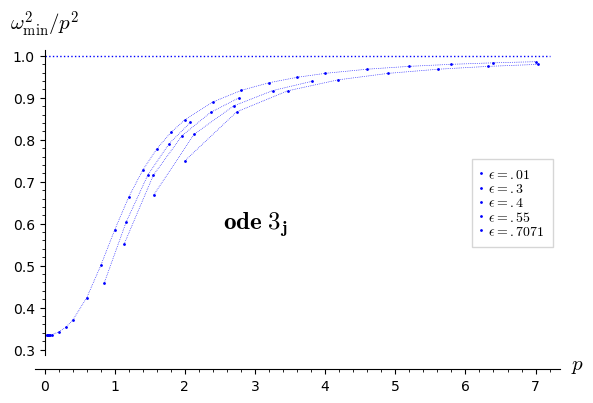

In [60]:
p=\
list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.3'],legend_label=r'$\epsilon=.3$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.4'],legend_label=r'$\epsilon=.4$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.55'],legend_label=r'$\epsilon=.55$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.7071'],legend_label=r'$\epsilon=.7071$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+text(r"${\bf ode~3_j}$",(3,.6),fontsize=18,color='black')\
+line([(0,1),(7.2,1)],linestyle=":")
p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.axes_labels_size(1.5)
p.show(ticks_integer=True,ymin=0.3)
p.save('3j_finite.pdf',dpi=600,ticks_integer=True,ymin=0.3)

In [61]:
ode_name='3j'
plot_data_asymp =[]
for key,item in data[ode_name]['asymp'].items():
    sigmaval = item['sigmaval']
    pval = sqrt(6)*sigmaval
    p = RDF(pval)
    fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
    plot_data_asymp.append((p,fs_ratio))

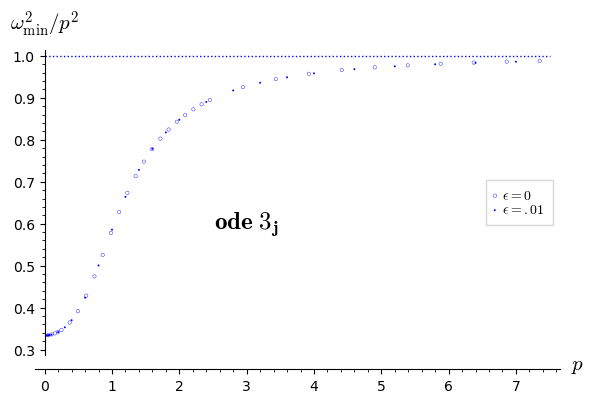

In [62]:
p=\
list_plot(plot_data_asymp,legend_label=r'$\epsilon=0$',marker=r'$\circ$',size=10)\
+list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',size=8)\
+text(r"${\bf ode~3_j}$",(3,.6),fontsize=18,color='black')\
+line([(0,1),(7.5,1)],linestyle=":")
p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.axes_labels_size(1.5)
p.show(ticks_integer=True,ymin=0.3)
p.save('3j_asymp.pdf',dpi=600,ticks_integer=True,ymin=0.3)


In [63]:
ode_name='2j'
plot_data_j ={}
for eps_string,eps_data in data[ode_name]['finite'].items():
    if eps_string not in plot_data_j:
        plot_data_j[eps_string]=[]
    for jval,item in eps_data.items():
        sigmaval = item['sigmaval']
        pval = 2*sigmaval
        p = RDF(pval)
        fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
        plot_data_j[eps_string].append((p,fs_ratio))
epsvals= list(plot_data_j.keys())
epsvals.sort()
print(epsvals)

['0.01', '0.08', '0.1', '0.125', '0.15', '0.2', '0.25', '0.325', '0.4', '0.5', '0.6', '0.7071']


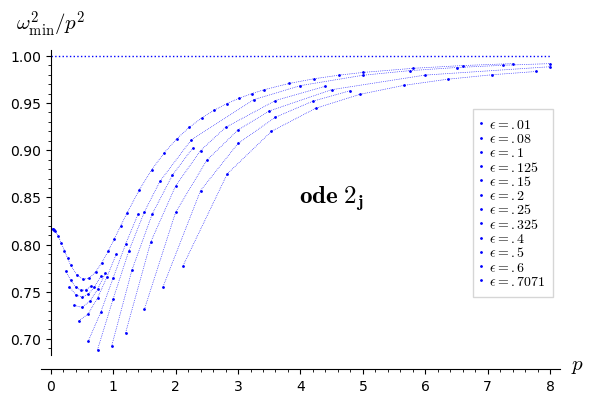

In [64]:
p=\
list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.08'],legend_label=r'$\epsilon=.08$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.1'],legend_label=r'$\epsilon=.1$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.125'],legend_label=r'$\epsilon=.125$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.15'],legend_label=r'$\epsilon=.15$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.2'],legend_label=r'$\epsilon=.2$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.25'],legend_label=r'$\epsilon=.25$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.325'],legend_label=r'$\epsilon=.325$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.4'],legend_label=r'$\epsilon=.4$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.5'],legend_label=r'$\epsilon=.5$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.6'],legend_label=r'$\epsilon=.6$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.7071'],legend_label=r'$\epsilon=.7071$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+text(r"${\bf ode~2_j}$",(4.5,.85),fontsize=18,color='black')\
+line([(0,1),(8,1)],linestyle=":")
p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.axes_labels_size(1.5)
p.show(ticks_integer=True,xmin=0)
p.save('2j_finite.pdf',dpi=600,ticks_integer=True,xmin=0)

In [65]:
ode_name='2j'
plot_data_asymp =[]
for key,item in data[ode_name]['asymp'].items():
    sigmaval = item['sigmaval']
    pval = 2*sigmaval
    p = RDF(pval)
    fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
    plot_data_asymp.append((p,fs_ratio))

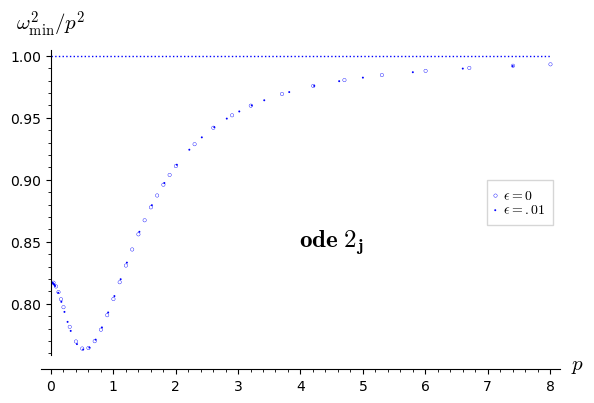

In [66]:
p=list_plot(plot_data_asymp,legend_label=r'$\epsilon=0$',marker=r'$\circ$',size=10)\
+list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',size=8)\
+text(r"${\bf ode~2_j}$",(4.5,.85),fontsize=18,color='black')\
+line([(0,1),(8.0,1)],linestyle=":")
p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.axes_labels_size(1.5)
p.show(ticks_integer=True)
p.save('2j_asymp.pdf',dpi=600,ticks_integer=True)


In [67]:
ode_name='1j'
plot_data_j ={}
for eps_string,eps_data in data[ode_name]['finite'].items():
    if eps_string not in plot_data_j:
        plot_data_j[eps_string]=[]
    for jval,item in eps_data.items():
        sigmaval = item['sigmaval']
        epsval = item['epsilonb']
        pval = sqrt(4*sigmaval^2+3*epsval^2)
        p = RDF(pval)
        fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
        plot_data_j[eps_string].append((p,fs_ratio))
epsvals= list(plot_data_j.keys())
epsvals.sort()
print(epsvals)

['0.001', '0.01', '0.15', '0.25', '0.35', '0.5', '0.7071']


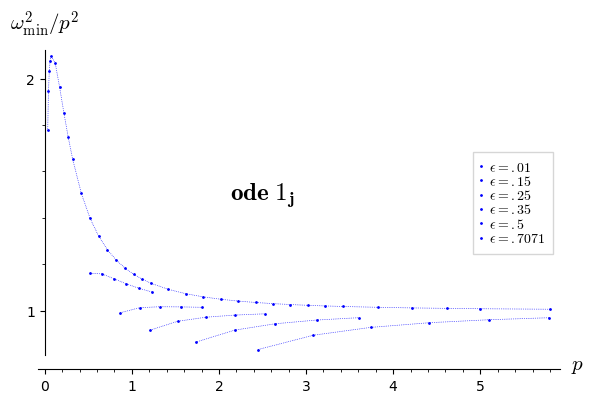

In [68]:
p=\
list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.15'],legend_label=r'$\epsilon=.15$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.25'],legend_label=r'$\epsilon=.25$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.35'],legend_label=r'$\epsilon=.35$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.5'],legend_label=r'$\epsilon=.5$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+list_plot(plot_data_j['0.7071'],legend_label=r'$\epsilon=.7071$',marker='.',markersize=2,plotjoined=True,linestyle=":",thickness=0.5)\
+text(r"${\bf ode~1_j}$",(2.5,1.5),fontsize=18,color='black')
p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.axes_labels_size(1.5)
p.show(ticks_integer=True)
p.save('1j_finite.pdf',dpi=600,ticks_integer=True)

In [69]:
ode_name='1j'
plot_data_asymp =[]
for key,item in data[ode_name]['asymp'].items():
    sigmaval = item['sigmaval']
    pval = 2*sigmaval
#    pval = sqrt(4*sigmaval^2+3*epsval^2)
    p = RDF(pval)
    fs_ratio = RDF(item['fs_ratio']*sigmaval^2/pval^2)
    plot_data_asymp.append((p,fs_ratio))

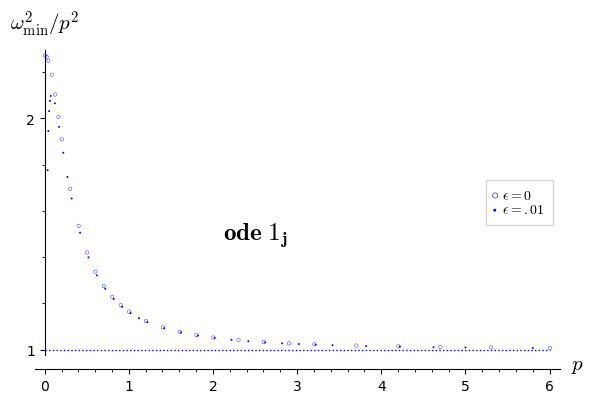

In [70]:
p=list_plot(plot_data_asymp,legend_label=r'$\epsilon=0$',marker=r'$\circ$',size=10)\
+list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='.',size=8)\
+text(r"${\bf ode~1_j}$",(2.5,1.5),fontsize=18,color='black')\
+line([(0,1),(6.0,1)],linestyle=":")
#p.set_legend_options(loc='center right',markerscale=1,numpoints=1,shadow=False)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.set_legend_options(loc='center right',markerscale=1.5,shadow=False)
p.axes_labels_size(1.5)
p.show(ticks_integer=True,ymin=1)
p.save('1j_asymp.pdf',dpi=600,ticks_integer=True,ymin=1)



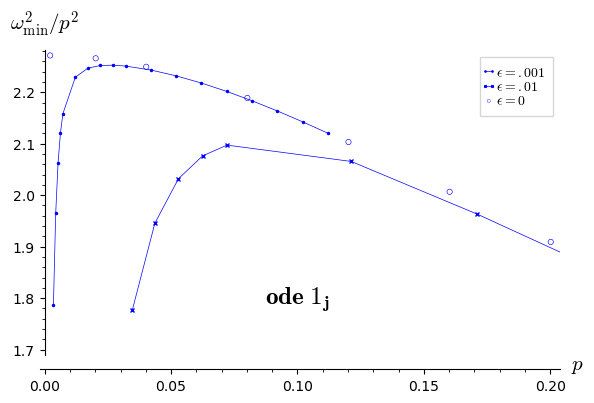

In [78]:
p=list_plot(plot_data_asymp,legend_label=r'$\epsilon=0$',marker=r'$\circ$',size=24)\
+list_plot(plot_data_j['0.001'],legend_label=r'$\epsilon=.001$',marker='.',markersize=3,plotjoined=True,thickness=0.5)\
+text(r"${\bf ode~1_j}$",(0.1,1.8),fontsize=18,color='black')\
+list_plot(plot_data_j['0.01'],legend_label=r'$\epsilon=.01$',marker='x',markersize=3,plotjoined=True,thickness=0.5)
p.axes_labels(['$p$','$\\omega_{\\min}^2/p^2$'])
p.set_legend_options(shadow=False)
#p.set_legend_options(loc='center right',markerscale=1.5,shadow=False)
p.axes_labels_size(1.5)
p.show(xmax=.2,ymin=1.7)
p.save('1j_smallp.pdf',dpi=600,xmax=.2,ymin=1.7)